In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
import warnings
warnings.filterwarnings("ignore")

# Forecasting
import prophet
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

In [5]:
df=pd.read_csv('cast.csv')
df

,Unnamed: 0,ds,y
0,0,2021-02-05,32318.501953
1,1,2021-02-06,32318.501953
2,2,2021-02-07,32318.501953
3,3,2021-02-08,32256.154297
4,4,2021-02-09,32235.369141
...,...,...,...
1456,1456,2025-01-31,11250.000000
1457,1457,2025-02-01,11250.000000
1458,1458,2025-02-02,11250.000000
1459,1459,2025-02-03,10875.000000


In [3]:
# df=df.drop(columns=['Unnamed: 0'])
# df

In [4]:
# # Ensure 'Date' is a datetime type
# df['ds'] = pd.to_datetime(df['ds'])

# # Sort the data by date
# df = df.sort_values(by='ds')

# df.info()

In [5]:
# df.describe(exclude='datetime')

In [6]:
# df.isna().sum()

`Spliting Data`

In [8]:
# # Define the split based on years
# df_train = df[df['ds'] < '2024-01-01']
# df_valid = df[df['ds'] >= '2024-01-01']

# # Check the split
# print("Training set:", df_train.shape)
# print("Validation set:", df_valid.shape)

In [9]:
# display(df_train, df_valid)

`EDA`

In [11]:
# plt.figure(figsize=(35,15))
# sns.lineplot(data=df, x='ds', y='y')
# plt.xticks(rotation=45, fontsize=20)
# plt.yticks(fontsize=20) 
# plt.xlabel("Date", fontsize=25) 
# plt.ylabel("Stock Price", fontsize=25)
# plt.title("Gudang Garam Stock Price Trend", fontsize=30) 
# plt.grid()
# plt.show()

In [12]:
# # Attempting to save the visualizations again for monthly and yearly boxplots separately

# # Monthly Boxplot
# plt.figure(figsize=(12, 6))
# sns.boxplot(x=df['month'], y=df['y'], palette='coolwarm', flierprops={'marker': 'o', 'color': 'black', 'markersize': 5})
# plt.title('Stock Price Distribution by Month')
# plt.xlabel('Month')
# plt.ylabel('Stock Price')
# plt.grid()
# plt.tight_layout()
# plt.savefig('monthly_boxplot_v2.png')
# plt.close()

# # Yearly Boxplot (Excluding 2025)
# plt.figure(figsize=(12, 6))
# sns.boxplot(x=df_filtered['year'], y=df_filtered['y'], palette='coolwarm', flierprops={'marker': 'o', 'color': 'black', 'markersize': 5})
# plt.title('Stock Price Distribution by Year (Excluding 2025)')
# plt.xlabel('Year')
# plt.ylabel('Stock Price')
# plt.grid()
# plt.tight_layout()
# plt.savefig('yearly_boxplot_v2.png')
# plt.close()

# # Provide the paths
# monthly_path = 'monthly_boxplot_v2.png'
# yearly_path = 'yearly_boxplot_v2.png'

# monthly_path, yearly_path


In [13]:
# # Plot ACF and PACF
# plt.figure(figsize=(12, 6))
# plt.subplot(121)
# plot_acf(df['Close'], lags=20, ax=plt.gca())
# plt.title('ACF Plot')

# plt.subplot(122)
# plot_pacf(df['Close'], lags=20, ax=plt.gca())
# plt.title('PACF Plot')

# plt.tight_layout()
# plt.show()

# `ARIMA`

`Finding the Best P, D, Q`

In [16]:
# import pandas as pd
# from statsmodels.tsa.arima.model import ARIMA
# from sklearn.metrics import mean_absolute_error
# import numpy as np

# # Prepare storage for results
# results = []

# # Loop through p, d, and q values from 1 to 20
# for p in range(1, 6):
#     for d in range(1, 6):
#         for q in range(1, 6):
#             try:
#                 # Fit ARIMA model with current p, d, q
#                 model = ARIMA(df_train['y'], order=(p, d, q))
#                 arima_result = model.fit()

#                 # Forecast for the validation dataset
#                 forecast = arima_result.forecast(steps=len(df_valid))

#                 # Calculate MAE
#                 mae = mean_absolute_error(df_valid['y'], forecast)

#                 # Calculate MAPE
#                 mape = np.mean(np.abs((df_valid['y'] - forecast) / df_valid['y'])) * 100

#                 # Append results
#                 results.append({
#                     'p': p, 'd': d, 'q': q, 
#                     'AIC': arima_result.aic, 
#                     'BIC': arima_result.bic, 
#                     'MAE': mae, 
#                     'MAPE': mape
#                 })
#             except Exception as e:
#                 # Append failure
#                 results.append({
#                     'p': p, 'd': d, 'q': q, 
#                     'AIC': None, 
#                     'BIC': None, 
#                     'MAE': None, 
#                     'MAPE': None
#                 })

# # Convert results to a DataFrame for analysis
# results_df = pd.DataFrame(results)

# # Find the best combination based on the lowest MAE
# best_result_mae = results_df.loc[results_df['MAE'].idxmin()]

# # Find the best combination based on the lowest MAPE
# best_result_mape = results_df.loc[results_df['MAPE'].idxmin()]


In [17]:
# display(results_df, best_result_mae, best_result_mape)

In [18]:
# import matplotlib.pyplot as plt

# # Visualization of Validation vs Predicted Trend
# plt.figure(figsize=(14, 7))

# # Plot training data
# plt.plot(df_train.index, df_train['y'], label='Training Data', color='blue', alpha=0.6)

# # Plot actual validation/test values
# plt.plot(df_valid.index, df_valid['y'], label='Actual Values (Validation)', color='green', alpha=0.6)

# # Plot predicted values
# plt.plot(df_valid.index, forecast, label='Predicted Values (ARIMA)', color='red', linestyle='--')

# # Highlight train/test split with a vertical line
# plt.axvline(df_valid.index[0], color='gray', linestyle='--', label='Train/Test Split')

# # Titles and labels
# plt.title('Validation vs Predicted Trend (ARIMA)', fontsize=14)
# plt.xlabel('Date', fontsize=12)
# plt.ylabel('Stock Price', fontsize=12)
# plt.legend()
# plt.grid(True, linestyle='--', alpha=0.7)
# plt.tight_layout()
# plt.show()

In [19]:
# from sklearn.metrics import mean_absolute_error
# import numpy as np
# import matplotlib.pyplot as plt
# from statsmodels.tsa.arima.model import ARIMA

# # Fit ARIMA model with specified parameters
# arima_model = ARIMA(df_train['y'], order=(1, 3, 3))
# arima_result = arima_model.fit()

# # Forecast for the validation dataset
# forecast_arima = arima_result.get_prediction(start=df_valid.index[0], end=df_valid.index[-1], dynamic=False)
# forecast_conf_int = forecast_arima.conf_int()  # Get confidence intervals

# # Extract predicted mean
# forecast_values = forecast_arima.predicted_mean

# # Calculate MAE
# mae_arima = mean_absolute_error(df_valid['y'], forecast_values)

# # Calculate MAPE
# mape_arima = np.mean(np.abs((df_valid['y'] - forecast_values) / df_valid['y'])) * 100

# # Visualization: Actual vs Predicted Values with Confidence Intervals
# plt.figure(figsize=(14, 7))

# # Plot actual values
# plt.plot(df_valid.index, df_valid['y'], label='Actual Values (Validation)', color='green', alpha=0.6, linewidth=2)

# # Plot predicted values
# plt.plot(df_valid.index, forecast_values, label='Predicted Values (ARIMA)', color='red', linestyle='--', linewidth=2)

# # Plot confidence intervals
# plt.fill_between(
#     df_valid.index,
#     forecast_conf_int.iloc[:, 0],  # Lower bound
#     forecast_conf_int.iloc[:, 1],  # Upper bound
#     color='pink', alpha=0.3,
#     label='Confidence Interval'
# )

# # Add title and labels
# plt.title('ARIMA Model (p=1, d=3, q=3): Actual vs Predicted Values', fontsize=16)
# plt.xlabel('Date', fontsize=12)
# plt.ylabel('Stock Price', fontsize=12)
# plt.legend()
# plt.grid(True, linestyle='--', alpha=0.7)
# plt.tight_layout()
# plt.show()

# # Return the metrics
# mae_arima, mape_arima

In [20]:
# import matplotlib.pyplot as plt

# # Visualization: Actual vs Predicted Values
# plt.figure(figsize=(14, 7))

# # Plot actual validation/test values
# plt.plot(df_valid.index, df_valid['y'], label='Actual Values (Validation)', color='green', alpha=0.6, linewidth=2)

# # Plot predicted values
# plt.plot(df_valid.index, forecast_arima, label='Predicted Values (ARIMA)', color='red', linestyle='--', linewidth=2)

# # Add title and labels
# plt.title('ARIMA Model: Actual vs Predicted Values', fontsize=16)
# plt.xlabel('Date', fontsize=12)
# plt.ylabel('Stock Price', fontsize=12)

# # Add legend and grid
# plt.legend()
# plt.grid(True, linestyle='--', alpha=0.7)

# # Display the plot
# plt.tight_layout()
# plt.show()

In [21]:
# import matplotlib.pyplot as plt

# # Fit ARIMA model with optimal parameters
# optimal_model = ARIMA(df_train['y'], order=(1, 3, 3))
# optimal_result = optimal_model.fit()

# # Forecast using the optimal model
# optimal_forecast = optimal_result.forecast(steps=len(df_valid))

# # Visualization: Actual vs Predicted Values
# plt.figure(figsize=(14, 7))
# plt.plot(df_valid.index, df_valid['y'], label='Actual Values (Validation)', color='green', alpha=0.6, linewidth=2)
# plt.plot(df_valid.index, optimal_forecast, label='Predicted Values (ARIMA)', color='red', linestyle='--', linewidth=2)
# plt.title('ARIMA Model (p=1, d=3, q=3): Actual vs Predicted Values', fontsize=16)
# plt.xlabel('Date', fontsize=12)
# plt.ylabel('Stock Price', fontsize=12)
# plt.legend()
# plt.grid(True, linestyle='--', alpha=0.7)
# plt.tight_layout()
# plt.show()

In [22]:
# # Optimal differencing using ADF test
# import pandas as pd
# from statsmodels.tsa.arima.model import ARIMA
# from sklearn.metrics import mean_absolute_error
# import pmdarima as pm
# from statsmodels.tsa.stattools import adfuller

# def get_optimal_d(series):
#     p_val = adfuller(series)[1]
#     d = 0
#     while p_val > 0.05:
#         d += 1
#         series = series.diff().dropna()
#         p_val = adfuller(series)[1]
#     return d

# d_optimal = get_optimal_d(df_train['y'])

# # Auto-tune SARIMA with pmdarima
# model = pm.auto_arima(
#     df_train['y'],
#     d=d_optimal,
#     seasonal=True,  # Auto-detect seasonality
#     stepwise=True,
#     suppress_warnings=True
# )

# # Forecast and evaluate
# forecast = model.predict(len(df_valid))
# mae = mean_absolute_error(df_valid['y'], forecast)

In [23]:
# mae

In [24]:
# import pmdarima as pm
# model = pm.auto_arima(df_train['Close'], seasonal=False, stepwise=True)

In [25]:
# model

# `Prophet`

In [27]:
# import pandas as pd
# import numpy as np
# from prophet import Prophet
# from sklearn.metrics import mean_absolute_error
# from itertools import product
# import matplotlib.pyplot as plt


# df = pd.read_csv('cast.csv')
# # Menghapus kolom 'Unnamed: 0'
# df = df.drop(columns=['Unnamed: 0'])

# # Mengubah kolom 'ds' menjadi tipe datetime
# df['ds'] = pd.to_datetime(df['ds'], format='%Y-%m-%d')

# # --------------------------------------------
# # BAGIAN 1: TRAIN-TEST SPLIT & PARAMETER GRID
# # --------------------------------------------
# # Data train (2021-02-05 sampai 2023-12-31)
# df_train = df[(df['ds'] >= '2021-02-05') & (df['ds'] <= '2023-12-31')]
# # Data test (2024-01-01 sampai 2025-02-04)
# df_test = df[(df['ds'] >= '2024-01-01') & (df['ds'] <= '2025-02-04')]

# # Parameter grid untuk Prophet
# param_grid = {
#     'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
#     'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
#     'seasonality_mode': ['additive', 'multiplicative'],
#     'n_changepoints': [20, 30, 40]
# }

# # Generate all combinations of parameters
# all_params = list(product(param_grid['changepoint_prior_scale'],
#                           param_grid['seasonality_prior_scale'],
#                           param_grid['seasonality_mode'],
#                           param_grid['n_changepoints']))

# best_mae = float("inf")
# best_params = None

# # --------------------------------------------
# # BAGIAN 2: CARI PARAMETER TERBAIK BERDASARKAN MAE
# # --------------------------------------------
# for params in all_params:
#     changepoint_prior_scale, seasonality_prior_scale, seasonality_mode, n_changepoints = params
    
#     try:
#         # Initialize and fit the Prophet model with current parameters
#         model = Prophet(
#             changepoint_prior_scale=changepoint_prior_scale,
#             seasonality_prior_scale=seasonality_prior_scale,
#             seasonality_mode=seasonality_mode,
#             n_changepoints=n_changepoints
#         )
#         model.fit(df_train)
        
#         # Create a future dataframe for predictions
#         future = model.make_future_dataframe(periods=len(df_test), include_history=False)
        
#         # Make predictions
#         forecast = model.predict(future)
#         predicted_values = forecast[['ds', 'yhat']].rename(columns={'yhat': 'predicted'})
        
#         # Merge predictions with actual test data
#         results_df = pd.merge(df_test, predicted_values, on='ds', how='inner')
        
#         # Calculate MAE
#         mae = mean_absolute_error(results_df['y'], results_df['predicted'])
        
#         print(f'Prophet Params: {params} - MAE: {mae:.2f}')
        
#         if mae < best_mae:
#             best_mae = mae
#             best_params = params
#     except Exception as e:
#         print(f"Gagal untuk Prophet Params: {params}: {str(e)}")
#         continue

# print(f'\nBest Model: Prophet Params: {best_params} - MAE: {best_mae:.2f}')

# # --------------------------------------------
# # BAGIAN 3: FIT MODEL TERBAIK KE SELURUH DATA (2021-02-05 sampai 2025-02-04)
# # --------------------------------------------
# # Gabungkan data train dan test untuk fitting final
# df_full = df[(df['ds'] >= '2021-02-05') & (df['ds'] <= '2025-02-04')]

# # Fit model terbaik ke data penuh
# final_model = Prophet(
#     changepoint_prior_scale=best_params[0],
#     seasonality_prior_scale=best_params[1],
#     seasonality_mode=best_params[2],
#     n_changepoints=best_params[3]
# )
# final_model.fit(df_full)

# print("\nModel terbaik telah di-fit ke seluruh data (2021-02-05 sampai 2025-02-04).")

# # --------------------------------------------
# # BAGIAN 4: PREDIKSI UNTUK PERIODE TEST (DARI MODEL TRAIN)
# # --------------------------------------------
# # Prediksi untuk periode test dari model yang di-fit ke data train
# model_train = Prophet(
#     changepoint_prior_scale=best_params[0],
#     seasonality_prior_scale=best_params[1],
#     seasonality_mode=best_params[2],
#     n_changepoints=best_params[3]
# )
# model_train.fit(df_train)

# # Create a future dataframe for predictions
# future = model_train.make_future_dataframe(periods=len(df_test), include_history=False)

# # Make predictions
# forecast = model_train.predict(future)
# predicted_values = forecast[['ds', 'yhat']].rename(columns={'yhat': 'predicted'})

# # Gabungkan hasil prediksi dan aktual
# df_forecast = pd.DataFrame({
#     'Date': df_test['ds'].values,
#     'Forecast': predicted_values['predicted'].values,
#     'Actual': df_test['y'].values
# })

# # Plot hasil
# plt.figure(figsize=(12, 6))
# plt.plot(df_train['ds'], df_train['y'], label='Train (2021-02-05 sampai 2023-12-31)')
# plt.plot(df_forecast['Date'], df_forecast['Actual'], label='Actual (2024-01-01 sampai 2025-02-04)', color='green')
# plt.plot(df_forecast['Date'], df_forecast['Forecast'], label='Forecast (2024-01-01 sampai 2025-02-04)', color='red', linestyle='--')
# plt.title('Perbandingan Forecast vs Actual (2024-01-01 sampai 2025-02-04)')
# plt.legend()
# plt.show()

# # Tampilkan tabel
# print("\nPerbandingan Forecast vs Actual (2024-01-01 sampai 2025-02-04):")
# display(df_forecast)

In [28]:
# plt.figure(figsize=(12, 6))
# plt.plot(df_train['ds'], df_train['y'], label='Train (2021-02-05 sampai 2023-12-31)')
# plt.plot(df_forecast['Date'], df_forecast['Actual'], label='Actual (2024-01-01 sampai 2025-02-04)', color='green')
# plt.plot(df_forecast['Date'], df_forecast['Forecast'], label='Forecast (2024-01-01 sampai 2025-02-04)', color='red', linestyle='--')
# plt.title('Perbandingan Forecast vs Actual (2024-01-01 sampai 2025-02-04)')
# plt.legend()
# plt.show()

# # Tampilkan tabel
# print("\nPerbandingan Forecast vs Actual (2024-01-01 sampai 2025-02-04):")
# display(df_forecast)

In [29]:
# import pandas as pd
# import numpy as np
# from prophet import Prophet
# from sklearn.metrics import mean_absolute_error
# from itertools import product
# import matplotlib.pyplot as plt

# df = pd.read_csv('cast.csv')
# # Menghapus kolom 'Unnamed: 0'
# df = df.drop(columns=['Unnamed: 0'])

# # Mengubah kolom 'ds' menjadi tipe datetime
# df['ds'] = pd.to_datetime(df['ds'], format='%Y-%m-%d')

# # --------------------------------------------
# # ADDING ADDITIONAL REGRESSORS
# # --------------------------------------------
# # Generate or load these regressors
# df['holiday_index'] = np.random.uniform(0, 1, len(df))  # Example: Random data
# df['macro_factor'] = np.random.uniform(0, 1, len(df))  # Example: Random data

# # Train-test split
# df_train = df[(df['ds'] >= '2021-02-05') & (df['ds'] <= '2023-12-31')]
# df_test = df[(df['ds'] >= '2024-01-01') & (df['ds'] <= '2025-02-04')]

# # Parameter grid for Prophet
# param_grid = {
#     'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
#     'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
#     'seasonality_mode': ['additive', 'multiplicative'],
#     'n_changepoints': [20, 30, 40]
# }

# # Generate all combinations of parameters
# all_params = list(product(param_grid['changepoint_prior_scale'],
#                           param_grid['seasonality_prior_scale'],
#                           param_grid['seasonality_mode'],
#                           param_grid['n_changepoints']))

# best_mae = float("inf")
# best_params = None

# # --------------------------------------------
# # SEARCH FOR BEST PARAMETERS
# # --------------------------------------------
# for params in all_params:
#     changepoint_prior_scale, seasonality_prior_scale, seasonality_mode, n_changepoints = params
    
#     try:
#         # Initialize and fit the Prophet model with additional regressors
#         model = Prophet(
#             changepoint_prior_scale=changepoint_prior_scale,
#             seasonality_prior_scale=seasonality_prior_scale,
#             seasonality_mode=seasonality_mode,
#             n_changepoints=n_changepoints
#         )
        
#         # Add regressors to the model
#         model.add_regressor('holiday_index')
#         model.add_regressor('macro_factor')
        
#         model.fit(df_train)
        
#         # Create a future dataframe for predictions
#         future = model.make_future_dataframe(periods=len(df_test), include_history=False)
        
#         # Add regressors to the future dataframe
#         future['holiday_index'] = df_test['holiday_index'].values
#         future['macro_factor'] = df_test['macro_factor'].values
        
#         # Make predictions
#         forecast = model.predict(future)
#         predicted_values = forecast[['ds', 'yhat']].rename(columns={'yhat': 'predicted'})
        
#         # Merge predictions with actual test data
#         results_df = pd.merge(df_test, predicted_values, on='ds', how='inner')
        
#         # Calculate MAE
#         mae = mean_absolute_error(results_df['y'], results_df['predicted'])
        
#         print(f'Prophet Params: {params} - MAE: {mae:.2f}')
        
#         if mae < best_mae:
#             best_mae = mae
#             best_params = params
#     except Exception as e:
#         print(f"Gagal untuk Prophet Params: {params}: {str(e)}")
#         continue

# print(f'\nBest Model: Prophet Params: {best_params} - MAE: {best_mae:.2f}')

# # --------------------------------------------
# # FIT BEST MODEL TO TRAINING DATA AND PREDICT TEST PERIOD
# # --------------------------------------------
# # Fit the best model on TRAINING data (not full data)
# final_model = Prophet(
#     changepoint_prior_scale=best_params[0],
#     seasonality_prior_scale=best_params[1],
#     seasonality_mode=best_params[2],
#     n_changepoints=best_params[3]
# )
# final_model.add_regressor('holiday_index')
# final_model.add_regressor('macro_factor')
# final_model.fit(df_train)  # Train on df_train only

# # Create future dataframe for TEST period (no history)
# future = final_model.make_future_dataframe(periods=len(df_test), include_history=False)

# # Assign regressors from TEST data
# future['holiday_index'] = df_test['holiday_index'].values
# future['macro_factor'] = df_test['macro_factor'].values

# # Generate forecast
# forecast = final_model.predict(future)

# # Extract relevant forecast and actuals
# df_forecast = forecast[['ds', 'yhat']].rename(columns={'yhat': 'Forecast'})
# df_forecast = pd.merge(df_test, df_forecast, on='ds', how='inner')

In [30]:
# # Plot results
# plt.figure(figsize=(14, 8))
# plt.plot(df_train['ds'], df_train['y'], label='Train (2021-02-05 to 2023-12-31)', color='blue')
# plt.plot(df_forecast['ds'], df_forecast['y'], label='Actual (2024-01-01 to 2025-02-04)', color='green')
# plt.plot(df_forecast['ds'], df_forecast['Forecast'], label='Forecast', color='red')
# plt.title('Forecast vs Actuals (No Data Leakage)', fontsize=16)
# plt.xlabel('Date')
# plt.ylabel('Stock Price')
# plt.legend()
# plt.grid(True, linestyle='--', alpha=0.6)
# plt.show()

`Prophet Model`

In [32]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_error
from itertools import product
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Load data
df = pd.read_csv('cast.csv').drop(columns=['Unnamed: 0'])
df['ds'] = pd.to_datetime(df['ds'], format='%Y-%m-%d')

# Generate synthetic regressors
np.random.seed(42)
df['holiday_index'] = np.random.uniform(0, 1, len(df))
df['macro_factor'] = np.random.uniform(0, 1, len(df))

# Train-test split
df_train = df[(df['ds'] >= '2021-02-05') & (df['ds'] <= '2023-12-31')]
df_test = df[(df['ds'] >= '2024-01-01') & (df['ds'] <= '2025-02-04')]

# Enhanced parameter grid
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative'],
    'n_changepoints': [25, 30, 35],
    'changepoint_range': [0.85, 0.9],
    'yearly_fourier_order': [8, 12]  # New parameter for custom seasonality    
}

# Performance metric calculation
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

best_mae = float("inf")
best_params = None
best_model = None

# Grid search implementation
for params in product(*param_grid.values()):
    try:
        # Unpack parameters
        (cps, sps, smode, ncp, crange, yfourier) = params
        
        # Initialize model with current parameters
        model = Prophet(
            changepoint_prior_scale=cps,
            seasonality_prior_scale=sps,
            seasonality_mode=smode,
            n_changepoints=ncp,
            changepoint_range=crange,
            yearly_seasonality=False  # Disable default yearly seasonality
        )
        
        # Add custom seasonality with specified Fourier order
        model.add_seasonality(
            name='yearly',
            period=365.25,
            fourier_order=yfourier
        )
        
        # Add regressors
        model.add_regressor('holiday_index')
        model.add_regressor('macro_factor')
        
        # Fit model
        model.fit(df_train)
        
        # Create future dataframe
        future = model.make_future_dataframe(periods=len(df_test), include_history=False)
        future['holiday_index'] = df_test['holiday_index'].values
        future['macro_factor'] = df_test['macro_factor'].values
        
        # Generate predictions
        forecast = model.predict(future)
        results = pd.merge(df_test, forecast[['ds', 'yhat']], on='ds')
        
        # Calculate metrics
        mae = mean_absolute_error(results['y'], results['yhat'])
        mape = mean_absolute_percentage_error(results['y'], results['yhat'])
        
        print(f"Params: {params} | MAE: {mae:.2f}, MAPE: {mape:.2f}%")
        
        if mae < best_mae:
            best_mae = mae
            best_mape = mape
            best_params = params
            best_model = model
            
    except Exception as e:
        print(f"Error with params {params}: {str(e)}")
        continue

print(f"\nBest Params: {best_params}")
print(f"Best MAE: {best_mae:.2f}, MAPE: {best_mape:.2f}%")

# Final model training and forecasting
full_model = Prophet(
    changepoint_prior_scale=best_params[0],
    seasonality_prior_scale=best_params[1],
    seasonality_mode=best_params[2],
    n_changepoints=best_params[3],
    changepoint_range=best_params[4],
    yearly_seasonality=False
).add_seasonality(
    name='yearly',
    period=365.25,
    fourier_order=best_params[5]
).add_regressor('holiday_index').add_regressor('macro_factor')

full_model.fit(df)

# Create 1-year future dataframe
future = full_model.make_future_dataframe(periods=365, freq='D')
future['holiday_index'] = np.random.uniform(0, 1, len(future))  # Replace with actual data
future['macro_factor'] = np.random.uniform(0, 1, len(future))   # Replace with actual data

# Generate forecast
forecast = full_model.predict(future)

12:47:53 - cmdstanpy - INFO - Chain [1] start processing
12:47:53 - cmdstanpy - INFO - Chain [1] done processing
12:47:53 - cmdstanpy - INFO - Chain [1] start processing
12:47:53 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 0.01, 'additive', 25, 0.85, 8) | MAE: 3702.06, MAPE: 23.60%


12:47:54 - cmdstanpy - INFO - Chain [1] start processing
12:47:54 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 0.01, 'additive', 25, 0.85, 12) | MAE: 3596.96, MAPE: 22.93%


12:47:54 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.001, 0.01, 'additive', 25, 0.9, 8) | MAE: 3857.75, MAPE: 24.64%


12:47:54 - cmdstanpy - INFO - Chain [1] done processing
12:47:54 - cmdstanpy - INFO - Chain [1] start processing
12:47:54 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 0.01, 'additive', 25, 0.9, 12) | MAE: 3719.18, MAPE: 23.71%


12:47:54 - cmdstanpy - INFO - Chain [1] start processing
12:47:55 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 0.01, 'additive', 30, 0.85, 8) | MAE: 3648.46, MAPE: 23.25%


12:47:55 - cmdstanpy - INFO - Chain [1] start processing
12:47:55 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 0.01, 'additive', 30, 0.85, 12) | MAE: 3635.57, MAPE: 23.17%


12:47:55 - cmdstanpy - INFO - Chain [1] start processing
12:47:55 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 0.01, 'additive', 30, 0.9, 8) | MAE: 3692.80, MAPE: 23.60%


12:47:55 - cmdstanpy - INFO - Chain [1] start processing
12:47:55 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 0.01, 'additive', 30, 0.9, 12) | MAE: 3611.31, MAPE: 23.02%


12:47:56 - cmdstanpy - INFO - Chain [1] start processing
12:47:56 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 0.01, 'additive', 35, 0.85, 8) | MAE: 3833.55, MAPE: 24.47%


12:47:56 - cmdstanpy - INFO - Chain [1] start processing
12:47:56 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 0.01, 'additive', 35, 0.85, 12) | MAE: 3905.86, MAPE: 24.91%


12:47:56 - cmdstanpy - INFO - Chain [1] start processing
12:47:56 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 0.01, 'additive', 35, 0.9, 8) | MAE: 3904.80, MAPE: 24.92%


12:47:56 - cmdstanpy - INFO - Chain [1] start processing
12:47:56 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 0.01, 'additive', 35, 0.9, 12) | MAE: 3681.16, MAPE: 23.49%


12:47:57 - cmdstanpy - INFO - Chain [1] start processing
12:47:57 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 0.01, 'multiplicative', 25, 0.85, 8) | MAE: 3678.12, MAPE: 23.89%


12:47:57 - cmdstanpy - INFO - Chain [1] start processing
12:47:57 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 0.01, 'multiplicative', 25, 0.85, 12) | MAE: 3770.87, MAPE: 24.45%


12:47:57 - cmdstanpy - INFO - Chain [1] start processing
12:47:57 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 0.01, 'multiplicative', 25, 0.9, 8) | MAE: 3744.05, MAPE: 24.29%


12:47:57 - cmdstanpy - INFO - Chain [1] start processing
12:47:58 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 0.01, 'multiplicative', 25, 0.9, 12) | MAE: 3695.07, MAPE: 23.99%


12:47:58 - cmdstanpy - INFO - Chain [1] start processing
12:47:58 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 0.01, 'multiplicative', 30, 0.85, 8) | MAE: 3554.06, MAPE: 23.13%


12:47:58 - cmdstanpy - INFO - Chain [1] start processing
12:47:58 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 0.01, 'multiplicative', 30, 0.85, 12) | MAE: 3497.07, MAPE: 22.74%


12:47:58 - cmdstanpy - INFO - Chain [1] start processing
12:47:58 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 0.01, 'multiplicative', 30, 0.9, 8) | MAE: 3920.98, MAPE: 25.42%


12:47:59 - cmdstanpy - INFO - Chain [1] start processing
12:47:59 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 0.01, 'multiplicative', 30, 0.9, 12) | MAE: 3579.87, MAPE: 23.30%


12:47:59 - cmdstanpy - INFO - Chain [1] start processing
12:47:59 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 0.01, 'multiplicative', 35, 0.85, 8) | MAE: 3702.86, MAPE: 24.09%


12:47:59 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.001, 0.01, 'multiplicative', 35, 0.85, 12) | MAE: 3703.24, MAPE: 24.04%


12:47:59 - cmdstanpy - INFO - Chain [1] done processing
12:47:59 - cmdstanpy - INFO - Chain [1] start processing
12:47:59 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 0.01, 'multiplicative', 35, 0.9, 8) | MAE: 3597.39, MAPE: 23.39%


12:48:00 - cmdstanpy - INFO - Chain [1] start processing
12:48:00 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 0.01, 'multiplicative', 35, 0.9, 12) | MAE: 3670.68, MAPE: 23.88%


12:48:00 - cmdstanpy - INFO - Chain [1] start processing
12:48:00 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 0.1, 'additive', 25, 0.85, 8) | MAE: 3819.48, MAPE: 24.32%


12:48:00 - cmdstanpy - INFO - Chain [1] start processing
12:48:00 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 0.1, 'additive', 25, 0.85, 12) | MAE: 3675.00, MAPE: 23.33%


12:48:01 - cmdstanpy - INFO - Chain [1] start processing
12:48:01 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 0.1, 'additive', 25, 0.9, 8) | MAE: 3932.83, MAPE: 24.98%


12:48:01 - cmdstanpy - INFO - Chain [1] start processing
12:48:01 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 0.1, 'additive', 25, 0.9, 12) | MAE: 3798.54, MAPE: 24.11%


12:48:01 - cmdstanpy - INFO - Chain [1] start processing
12:48:01 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 0.1, 'additive', 30, 0.85, 8) | MAE: 3507.55, MAPE: 22.26%


12:48:01 - cmdstanpy - INFO - Chain [1] start processing
12:48:01 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 0.1, 'additive', 30, 0.85, 12) | MAE: 3936.61, MAPE: 25.02%


12:48:02 - cmdstanpy - INFO - Chain [1] start processing
12:48:02 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 0.1, 'additive', 30, 0.9, 8) | MAE: 3776.67, MAPE: 23.99%


12:48:02 - cmdstanpy - INFO - Chain [1] start processing
12:48:02 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 0.1, 'additive', 30, 0.9, 12) | MAE: 3907.87, MAPE: 24.88%


12:48:02 - cmdstanpy - INFO - Chain [1] start processing
12:48:02 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 0.1, 'additive', 35, 0.85, 8) | MAE: 3836.70, MAPE: 24.41%


12:48:02 - cmdstanpy - INFO - Chain [1] start processing
12:48:02 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 0.1, 'additive', 35, 0.85, 12) | MAE: 3524.33, MAPE: 22.37%


12:48:03 - cmdstanpy - INFO - Chain [1] start processing
12:48:03 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 0.1, 'additive', 35, 0.9, 8) | MAE: 3620.43, MAPE: 23.02%


12:48:03 - cmdstanpy - INFO - Chain [1] start processing
12:48:03 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 0.1, 'additive', 35, 0.9, 12) | MAE: 3686.95, MAPE: 23.46%


12:48:03 - cmdstanpy - INFO - Chain [1] start processing
12:48:03 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 0.1, 'multiplicative', 25, 0.85, 8) | MAE: 3571.74, MAPE: 23.17%


12:48:03 - cmdstanpy - INFO - Chain [1] start processing
12:48:03 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 0.1, 'multiplicative', 25, 0.85, 12) | MAE: 3595.69, MAPE: 23.23%


12:48:04 - cmdstanpy - INFO - Chain [1] start processing
12:48:04 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 0.1, 'multiplicative', 25, 0.9, 8) | MAE: 3685.92, MAPE: 23.79%


12:48:04 - cmdstanpy - INFO - Chain [1] start processing
12:48:04 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 0.1, 'multiplicative', 25, 0.9, 12) | MAE: 3775.91, MAPE: 24.33%


12:48:04 - cmdstanpy - INFO - Chain [1] start processing
12:48:04 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 0.1, 'multiplicative', 30, 0.85, 8) | MAE: 3531.90, MAPE: 22.86%


12:48:04 - cmdstanpy - INFO - Chain [1] start processing
12:48:05 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 0.1, 'multiplicative', 30, 0.85, 12) | MAE: 3728.75, MAPE: 24.05%


12:48:05 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.001, 0.1, 'multiplicative', 30, 0.9, 8) | MAE: 3748.93, MAPE: 24.19%


12:48:05 - cmdstanpy - INFO - Chain [1] done processing
12:48:05 - cmdstanpy - INFO - Chain [1] start processing
12:48:05 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 0.1, 'multiplicative', 30, 0.9, 12) | MAE: 3645.12, MAPE: 23.58%


12:48:05 - cmdstanpy - INFO - Chain [1] start processing
12:48:05 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 0.1, 'multiplicative', 35, 0.85, 8) | MAE: 3803.35, MAPE: 24.46%


12:48:06 - cmdstanpy - INFO - Chain [1] start processing
12:48:06 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 0.1, 'multiplicative', 35, 0.85, 12) | MAE: 3674.00, MAPE: 23.62%


12:48:06 - cmdstanpy - INFO - Chain [1] start processing
12:48:06 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 0.1, 'multiplicative', 35, 0.9, 8) | MAE: 3594.68, MAPE: 23.17%


12:48:06 - cmdstanpy - INFO - Chain [1] start processing
12:48:06 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 0.1, 'multiplicative', 35, 0.9, 12) | MAE: 3854.19, MAPE: 24.72%


12:48:06 - cmdstanpy - INFO - Chain [1] start processing
12:48:07 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 1.0, 'additive', 25, 0.85, 8) | MAE: 3827.98, MAPE: 24.36%


12:48:07 - cmdstanpy - INFO - Chain [1] start processing
12:48:07 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 1.0, 'additive', 25, 0.85, 12) | MAE: 3783.20, MAPE: 24.05%


12:48:07 - cmdstanpy - INFO - Chain [1] start processing
12:48:07 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 1.0, 'additive', 25, 0.9, 8) | MAE: 3875.66, MAPE: 24.61%


12:48:07 - cmdstanpy - INFO - Chain [1] start processing
12:48:07 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 1.0, 'additive', 25, 0.9, 12) | MAE: 3792.63, MAPE: 24.12%


12:48:07 - cmdstanpy - INFO - Chain [1] start processing
12:48:08 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 1.0, 'additive', 30, 0.85, 8) | MAE: 3790.83, MAPE: 24.15%


12:48:08 - cmdstanpy - INFO - Chain [1] start processing
12:48:08 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 1.0, 'additive', 30, 0.85, 12) | MAE: 3880.15, MAPE: 24.70%


12:48:08 - cmdstanpy - INFO - Chain [1] start processing
12:48:08 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 1.0, 'additive', 30, 0.9, 8) | MAE: 3825.15, MAPE: 24.33%


12:48:08 - cmdstanpy - INFO - Chain [1] start processing
12:48:08 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 1.0, 'additive', 30, 0.9, 12) | MAE: 3841.86, MAPE: 24.42%


12:48:09 - cmdstanpy - INFO - Chain [1] start processing
12:48:09 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 1.0, 'additive', 35, 0.85, 8) | MAE: 3751.73, MAPE: 23.83%


12:48:09 - cmdstanpy - INFO - Chain [1] start processing
12:48:09 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 1.0, 'additive', 35, 0.85, 12) | MAE: 3677.42, MAPE: 23.33%


12:48:09 - cmdstanpy - INFO - Chain [1] start processing
12:48:09 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 1.0, 'additive', 35, 0.9, 8) | MAE: 3741.70, MAPE: 23.76%


12:48:09 - cmdstanpy - INFO - Chain [1] start processing
12:48:09 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 1.0, 'additive', 35, 0.9, 12) | MAE: 3706.19, MAPE: 23.53%


12:48:10 - cmdstanpy - INFO - Chain [1] start processing
12:48:10 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 1.0, 'multiplicative', 25, 0.85, 8) | MAE: 3586.95, MAPE: 23.18%


12:48:10 - cmdstanpy - INFO - Chain [1] start processing
12:48:10 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 1.0, 'multiplicative', 25, 0.85, 12) | MAE: 3574.56, MAPE: 23.10%


12:48:10 - cmdstanpy - INFO - Chain [1] start processing
12:48:10 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 1.0, 'multiplicative', 25, 0.9, 8) | MAE: 3758.82, MAPE: 24.21%


12:48:10 - cmdstanpy - INFO - Chain [1] start processing
12:48:10 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 1.0, 'multiplicative', 25, 0.9, 12) | MAE: 3990.53, MAPE: 25.70%


12:48:11 - cmdstanpy - INFO - Chain [1] start processing
12:48:11 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 1.0, 'multiplicative', 30, 0.85, 8) | MAE: 3628.07, MAPE: 23.43%


12:48:11 - cmdstanpy - INFO - Chain [1] start processing
12:48:11 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 1.0, 'multiplicative', 30, 0.85, 12) | MAE: 3761.81, MAPE: 24.24%


12:48:11 - cmdstanpy - INFO - Chain [1] start processing
12:48:11 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 1.0, 'multiplicative', 30, 0.9, 8) | MAE: 3852.36, MAPE: 24.81%


12:48:11 - cmdstanpy - INFO - Chain [1] start processing
12:48:11 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 1.0, 'multiplicative', 30, 0.9, 12) | MAE: 3836.19, MAPE: 24.77%


12:48:12 - cmdstanpy - INFO - Chain [1] start processing
12:48:12 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 1.0, 'multiplicative', 35, 0.85, 8) | MAE: 3725.70, MAPE: 24.00%


12:48:12 - cmdstanpy - INFO - Chain [1] start processing
12:48:12 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 1.0, 'multiplicative', 35, 0.85, 12) | MAE: 3805.58, MAPE: 24.45%


12:48:12 - cmdstanpy - INFO - Chain [1] start processing
12:48:12 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 1.0, 'multiplicative', 35, 0.9, 8) | MAE: 3787.42, MAPE: 24.38%


12:48:12 - cmdstanpy - INFO - Chain [1] start processing
12:48:13 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 1.0, 'multiplicative', 35, 0.9, 12) | MAE: 3697.60, MAPE: 23.83%


12:48:13 - cmdstanpy - INFO - Chain [1] start processing
12:48:13 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 10.0, 'additive', 25, 0.85, 8) | MAE: 3871.69, MAPE: 24.64%


12:48:13 - cmdstanpy - INFO - Chain [1] start processing
12:48:13 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 10.0, 'additive', 25, 0.85, 12) | MAE: 3741.69, MAPE: 23.75%


12:48:13 - cmdstanpy - INFO - Chain [1] start processing
12:48:13 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 10.0, 'additive', 25, 0.9, 8) | MAE: 3653.87, MAPE: 23.24%


12:48:13 - cmdstanpy - INFO - Chain [1] start processing
12:48:14 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 10.0, 'additive', 25, 0.9, 12) | MAE: 3848.10, MAPE: 24.46%


12:48:14 - cmdstanpy - INFO - Chain [1] start processing
12:48:14 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 10.0, 'additive', 30, 0.85, 8) | MAE: 4019.81, MAPE: 25.59%


12:48:14 - cmdstanpy - INFO - Chain [1] start processing
12:48:14 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 10.0, 'additive', 30, 0.85, 12) | MAE: 3852.34, MAPE: 24.52%


12:48:14 - cmdstanpy - INFO - Chain [1] start processing
12:48:14 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 10.0, 'additive', 30, 0.9, 8) | MAE: 3851.51, MAPE: 24.52%


12:48:14 - cmdstanpy - INFO - Chain [1] start processing
12:48:15 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 10.0, 'additive', 30, 0.9, 12) | MAE: 3909.06, MAPE: 24.84%


12:48:15 - cmdstanpy - INFO - Chain [1] start processing
12:48:15 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 10.0, 'additive', 35, 0.85, 8) | MAE: 3648.33, MAPE: 23.18%


12:48:15 - cmdstanpy - INFO - Chain [1] start processing
12:48:15 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 10.0, 'additive', 35, 0.85, 12) | MAE: 3540.25, MAPE: 22.46%


12:48:15 - cmdstanpy - INFO - Chain [1] start processing
12:48:15 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 10.0, 'additive', 35, 0.9, 8) | MAE: 3617.59, MAPE: 22.98%


12:48:16 - cmdstanpy - INFO - Chain [1] start processing
12:48:16 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 10.0, 'additive', 35, 0.9, 12) | MAE: 3588.74, MAPE: 22.79%


12:48:16 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.001, 10.0, 'multiplicative', 25, 0.85, 8) | MAE: 3559.91, MAPE: 23.01%


12:48:16 - cmdstanpy - INFO - Chain [1] done processing
12:48:16 - cmdstanpy - INFO - Chain [1] start processing
12:48:16 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 10.0, 'multiplicative', 25, 0.85, 12) | MAE: 3479.16, MAPE: 22.49%


12:48:17 - cmdstanpy - INFO - Chain [1] start processing
12:48:17 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 10.0, 'multiplicative', 25, 0.9, 8) | MAE: 3908.83, MAPE: 25.16%


12:48:17 - cmdstanpy - INFO - Chain [1] start processing
12:48:17 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 10.0, 'multiplicative', 25, 0.9, 12) | MAE: 3807.05, MAPE: 24.54%


12:48:17 - cmdstanpy - INFO - Chain [1] start processing
12:48:17 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 10.0, 'multiplicative', 30, 0.85, 8) | MAE: 3646.54, MAPE: 23.55%


12:48:17 - cmdstanpy - INFO - Chain [1] start processing
12:48:17 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 10.0, 'multiplicative', 30, 0.85, 12) | MAE: 3773.02, MAPE: 24.31%


12:48:18 - cmdstanpy - INFO - Chain [1] start processing
12:48:18 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 10.0, 'multiplicative', 30, 0.9, 8) | MAE: 3809.15, MAPE: 24.59%


12:48:18 - cmdstanpy - INFO - Chain [1] start processing
12:48:18 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 10.0, 'multiplicative', 30, 0.9, 12) | MAE: 3791.69, MAPE: 24.49%


12:48:18 - cmdstanpy - INFO - Chain [1] start processing
12:48:18 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 10.0, 'multiplicative', 35, 0.85, 8) | MAE: 3550.23, MAPE: 22.92%


12:48:18 - cmdstanpy - INFO - Chain [1] start processing
12:48:18 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 10.0, 'multiplicative', 35, 0.85, 12) | MAE: 3592.49, MAPE: 23.15%


12:48:19 - cmdstanpy - INFO - Chain [1] start processing
12:48:19 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 10.0, 'multiplicative', 35, 0.9, 8) | MAE: 3797.48, MAPE: 24.46%


12:48:19 - cmdstanpy - INFO - Chain [1] start processing
12:48:19 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 10.0, 'multiplicative', 35, 0.9, 12) | MAE: 3736.78, MAPE: 24.08%


12:48:19 - cmdstanpy - INFO - Chain [1] start processing
12:48:19 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.01, 0.01, 'additive', 25, 0.85, 8) | MAE: 7172.98, MAPE: 45.85%


12:48:20 - cmdstanpy - INFO - Chain [1] start processing
12:48:20 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.01, 0.01, 'additive', 25, 0.85, 12) | MAE: 7110.04, MAPE: 45.43%


12:48:20 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.01, 0.01, 'additive', 25, 0.9, 8) | MAE: 7342.29, MAPE: 46.95%


12:48:20 - cmdstanpy - INFO - Chain [1] done processing
12:48:20 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.01, 0.01, 'additive', 25, 0.9, 12) | MAE: 6959.17, MAPE: 44.47%


12:48:20 - cmdstanpy - INFO - Chain [1] done processing
12:48:21 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.01, 0.01, 'additive', 30, 0.85, 8) | MAE: 7228.18, MAPE: 46.21%


12:48:21 - cmdstanpy - INFO - Chain [1] done processing
12:48:21 - cmdstanpy - INFO - Chain [1] start processing
12:48:21 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.01, 0.01, 'additive', 30, 0.85, 12) | MAE: 7017.68, MAPE: 44.84%


12:48:21 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.01, 0.01, 'additive', 30, 0.9, 8) | MAE: 7143.93, MAPE: 45.65%


12:48:21 - cmdstanpy - INFO - Chain [1] done processing
12:48:21 - cmdstanpy - INFO - Chain [1] start processing
12:48:22 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.01, 0.01, 'additive', 30, 0.9, 12) | MAE: 6867.24, MAPE: 43.85%


12:48:22 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.01, 0.01, 'additive', 35, 0.85, 8) | MAE: 7260.35, MAPE: 46.44%


12:48:22 - cmdstanpy - INFO - Chain [1] done processing
12:48:22 - cmdstanpy - INFO - Chain [1] start processing
12:48:22 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.01, 0.01, 'additive', 35, 0.85, 12) | MAE: 7140.63, MAPE: 45.65%


12:48:22 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.01, 0.01, 'additive', 35, 0.9, 8) | MAE: 6983.52, MAPE: 44.61%


12:48:23 - cmdstanpy - INFO - Chain [1] done processing
12:48:23 - cmdstanpy - INFO - Chain [1] start processing
12:48:23 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.01, 0.01, 'additive', 35, 0.9, 12) | MAE: 6834.80, MAPE: 43.64%


12:48:23 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.01, 0.01, 'multiplicative', 25, 0.85, 8) | MAE: 6365.44, MAPE: 40.84%


12:48:23 - cmdstanpy - INFO - Chain [1] done processing
12:48:23 - cmdstanpy - INFO - Chain [1] start processing
12:48:23 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.01, 0.01, 'multiplicative', 25, 0.85, 12) | MAE: 6029.04, MAPE: 38.66%


12:48:24 - cmdstanpy - INFO - Chain [1] start processing
12:48:24 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.01, 0.01, 'multiplicative', 25, 0.9, 8) | MAE: 6067.46, MAPE: 38.89%


12:48:24 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.01, 0.01, 'multiplicative', 25, 0.9, 12) | MAE: 6246.29, MAPE: 40.04%


12:48:24 - cmdstanpy - INFO - Chain [1] done processing
12:48:24 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.01, 0.01, 'multiplicative', 30, 0.85, 8) | MAE: 5649.07, MAPE: 36.20%


12:48:24 - cmdstanpy - INFO - Chain [1] done processing
12:48:25 - cmdstanpy - INFO - Chain [1] start processing
12:48:25 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.01, 0.01, 'multiplicative', 30, 0.85, 12) | MAE: 5567.85, MAPE: 35.68%


12:48:25 - cmdstanpy - INFO - Chain [1] start processing
12:48:25 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.01, 0.01, 'multiplicative', 30, 0.9, 8) | MAE: 5714.03, MAPE: 36.61%


12:48:25 - cmdstanpy - INFO - Chain [1] start processing
12:48:25 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.01, 0.01, 'multiplicative', 30, 0.9, 12) | MAE: 5871.79, MAPE: 37.62%


12:48:25 - cmdstanpy - INFO - Chain [1] start processing
12:48:26 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.01, 0.01, 'multiplicative', 35, 0.85, 8) | MAE: 6052.72, MAPE: 38.82%


12:48:26 - cmdstanpy - INFO - Chain [1] start processing
12:48:26 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.01, 0.01, 'multiplicative', 35, 0.85, 12) | MAE: 5910.38, MAPE: 37.88%


12:48:26 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.01, 0.01, 'multiplicative', 35, 0.9, 8) | MAE: 6090.67, MAPE: 39.04%


12:48:26 - cmdstanpy - INFO - Chain [1] done processing
12:48:26 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.01, 0.01, 'multiplicative', 35, 0.9, 12) | MAE: 5818.22, MAPE: 37.28%


12:48:26 - cmdstanpy - INFO - Chain [1] done processing
12:48:27 - cmdstanpy - INFO - Chain [1] start processing
12:48:27 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.01, 0.1, 'additive', 25, 0.85, 8) | MAE: 7613.11, MAPE: 48.68%


12:48:27 - cmdstanpy - INFO - Chain [1] start processing
12:48:27 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.01, 0.1, 'additive', 25, 0.85, 12) | MAE: 7441.09, MAPE: 47.56%


12:48:27 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.01, 0.1, 'additive', 25, 0.9, 8) | MAE: 7759.32, MAPE: 49.62%


12:48:27 - cmdstanpy - INFO - Chain [1] done processing
12:48:28 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.01, 0.1, 'additive', 25, 0.9, 12) | MAE: 7334.13, MAPE: 46.85%


12:48:28 - cmdstanpy - INFO - Chain [1] done processing
12:48:28 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.01, 0.1, 'additive', 30, 0.85, 8) | MAE: 7629.52, MAPE: 48.78%


12:48:28 - cmdstanpy - INFO - Chain [1] done processing
12:48:28 - cmdstanpy - INFO - Chain [1] start processing
12:48:28 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.01, 0.1, 'additive', 30, 0.85, 12) | MAE: 7430.03, MAPE: 47.48%


12:48:29 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.01, 0.1, 'additive', 30, 0.9, 8) | MAE: 7532.97, MAPE: 48.16%


12:48:29 - cmdstanpy - INFO - Chain [1] done processing
12:48:29 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.01, 0.1, 'additive', 30, 0.9, 12) | MAE: 7452.38, MAPE: 47.63%


12:48:29 - cmdstanpy - INFO - Chain [1] done processing
12:48:29 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.01, 0.1, 'additive', 35, 0.85, 8) | MAE: 7550.06, MAPE: 48.27%


12:48:29 - cmdstanpy - INFO - Chain [1] done processing
12:48:30 - cmdstanpy - INFO - Chain [1] start processing
12:48:30 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.01, 0.1, 'additive', 35, 0.85, 12) | MAE: 7506.55, MAPE: 48.00%


12:48:30 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.01, 0.1, 'additive', 35, 0.9, 8) | MAE: 7810.63, MAPE: 49.97%


12:48:30 - cmdstanpy - INFO - Chain [1] done processing
12:48:30 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.01, 0.1, 'additive', 35, 0.9, 12) | MAE: 7084.35, MAPE: 45.23%


12:48:31 - cmdstanpy - INFO - Chain [1] done processing
12:48:31 - cmdstanpy - INFO - Chain [1] start processing
12:48:31 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.01, 0.1, 'multiplicative', 25, 0.85, 8) | MAE: 6781.49, MAPE: 43.45%


12:48:31 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.01, 0.1, 'multiplicative', 25, 0.85, 12) | MAE: 6772.56, MAPE: 43.38%


12:48:31 - cmdstanpy - INFO - Chain [1] done processing
12:48:31 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.01, 0.1, 'multiplicative', 25, 0.9, 8) | MAE: 7063.87, MAPE: 45.27%


12:48:32 - cmdstanpy - INFO - Chain [1] done processing
12:48:32 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.01, 0.1, 'multiplicative', 25, 0.9, 12) | MAE: 6581.82, MAPE: 42.14%


12:48:32 - cmdstanpy - INFO - Chain [1] done processing
12:48:32 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.01, 0.1, 'multiplicative', 30, 0.85, 8) | MAE: 6958.04, MAPE: 44.60%


12:48:32 - cmdstanpy - INFO - Chain [1] done processing
12:48:33 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.01, 0.1, 'multiplicative', 30, 0.85, 12) | MAE: 6466.04, MAPE: 41.41%


12:48:33 - cmdstanpy - INFO - Chain [1] done processing
12:48:33 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.01, 0.1, 'multiplicative', 30, 0.9, 8) | MAE: 6839.21, MAPE: 43.82%


12:48:33 - cmdstanpy - INFO - Chain [1] done processing
12:48:33 - cmdstanpy - INFO - Chain [1] start processing
12:48:33 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.01, 0.1, 'multiplicative', 30, 0.9, 12) | MAE: 6616.31, MAPE: 42.39%


12:48:34 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.01, 0.1, 'multiplicative', 35, 0.85, 8) | MAE: 6832.91, MAPE: 43.79%


12:48:34 - cmdstanpy - INFO - Chain [1] done processing
12:48:34 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.01, 0.1, 'multiplicative', 35, 0.85, 12) | MAE: 6595.60, MAPE: 42.24%


12:48:34 - cmdstanpy - INFO - Chain [1] done processing
12:48:34 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.01, 0.1, 'multiplicative', 35, 0.9, 8) | MAE: 6830.49, MAPE: 43.77%


12:48:34 - cmdstanpy - INFO - Chain [1] done processing
12:48:35 - cmdstanpy - INFO - Chain [1] start processing
12:48:35 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.01, 0.1, 'multiplicative', 35, 0.9, 12) | MAE: 6417.88, MAPE: 41.10%


12:48:35 - cmdstanpy - INFO - Chain [1] start processing
12:48:35 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.01, 1.0, 'additive', 25, 0.85, 8) | MAE: 7839.68, MAPE: 50.16%


12:48:35 - cmdstanpy - INFO - Chain [1] start processing
12:48:35 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.01, 1.0, 'additive', 25, 0.85, 12) | MAE: 7549.45, MAPE: 48.28%


12:48:36 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.01, 1.0, 'additive', 25, 0.9, 8) | MAE: 7854.31, MAPE: 50.23%


12:48:36 - cmdstanpy - INFO - Chain [1] done processing
12:48:36 - cmdstanpy - INFO - Chain [1] start processing
12:48:36 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.01, 1.0, 'additive', 25, 0.9, 12) | MAE: 7508.66, MAPE: 48.00%


12:48:36 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.01, 1.0, 'additive', 30, 0.85, 8) | MAE: 7599.60, MAPE: 48.58%


12:48:36 - cmdstanpy - INFO - Chain [1] done processing
12:48:37 - cmdstanpy - INFO - Chain [1] start processing
12:48:37 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.01, 1.0, 'additive', 30, 0.85, 12) | MAE: 7370.09, MAPE: 47.10%


12:48:37 - cmdstanpy - INFO - Chain [1] start processing
12:48:37 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.01, 1.0, 'additive', 30, 0.9, 8) | MAE: 7555.78, MAPE: 48.30%


12:48:37 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.01, 1.0, 'additive', 30, 0.9, 12) | MAE: 7450.17, MAPE: 47.62%


12:48:37 - cmdstanpy - INFO - Chain [1] done processing
12:48:38 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.01, 1.0, 'additive', 35, 0.85, 8) | MAE: 7557.70, MAPE: 48.33%


12:48:38 - cmdstanpy - INFO - Chain [1] done processing
12:48:38 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.01, 1.0, 'additive', 35, 0.85, 12) | MAE: 7473.11, MAPE: 47.78%


12:48:38 - cmdstanpy - INFO - Chain [1] done processing
12:48:38 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.01, 1.0, 'additive', 35, 0.9, 8) | MAE: 7256.68, MAPE: 46.36%


12:48:39 - cmdstanpy - INFO - Chain [1] done processing
12:48:39 - cmdstanpy - INFO - Chain [1] start processing
12:48:39 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.01, 1.0, 'additive', 35, 0.9, 12) | MAE: 7097.29, MAPE: 45.31%


12:48:39 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.01, 1.0, 'multiplicative', 25, 0.85, 8) | MAE: 6776.91, MAPE: 43.42%


12:48:39 - cmdstanpy - INFO - Chain [1] done processing
12:48:40 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.01, 1.0, 'multiplicative', 25, 0.85, 12) | MAE: 6506.28, MAPE: 41.67%


12:48:40 - cmdstanpy - INFO - Chain [1] done processing
12:48:40 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.01, 1.0, 'multiplicative', 25, 0.9, 8) | MAE: 6687.97, MAPE: 42.85%


12:48:40 - cmdstanpy - INFO - Chain [1] done processing
12:48:40 - cmdstanpy - INFO - Chain [1] start processing
12:48:40 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.01, 1.0, 'multiplicative', 25, 0.9, 12) | MAE: 6543.99, MAPE: 41.90%


12:48:41 - cmdstanpy - INFO - Chain [1] start processing
12:48:41 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.01, 1.0, 'multiplicative', 30, 0.85, 8) | MAE: 6937.92, MAPE: 44.45%


12:48:41 - cmdstanpy - INFO - Chain [1] start processing
12:48:41 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.01, 1.0, 'multiplicative', 30, 0.85, 12) | MAE: 6720.99, MAPE: 43.06%


12:48:41 - cmdstanpy - INFO - Chain [1] start processing
12:48:41 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.01, 1.0, 'multiplicative', 30, 0.9, 8) | MAE: 6747.76, MAPE: 43.23%


12:48:41 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.01, 1.0, 'multiplicative', 30, 0.9, 12) | MAE: 6694.44, MAPE: 42.88%


12:48:42 - cmdstanpy - INFO - Chain [1] done processing
12:48:42 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.01, 1.0, 'multiplicative', 35, 0.85, 8) | MAE: 6778.57, MAPE: 43.43%


12:48:42 - cmdstanpy - INFO - Chain [1] done processing
12:48:42 - cmdstanpy - INFO - Chain [1] start processing
12:48:42 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.01, 1.0, 'multiplicative', 35, 0.85, 12) | MAE: 6790.82, MAPE: 43.50%


12:48:42 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.01, 1.0, 'multiplicative', 35, 0.9, 8) | MAE: 6693.86, MAPE: 42.88%


12:48:42 - cmdstanpy - INFO - Chain [1] done processing
12:48:43 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.01, 1.0, 'multiplicative', 35, 0.9, 12) | MAE: 6626.45, MAPE: 42.44%


12:48:43 - cmdstanpy - INFO - Chain [1] done processing
12:48:43 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.01, 10.0, 'additive', 25, 0.85, 8) | MAE: 7572.44, MAPE: 48.41%


12:48:43 - cmdstanpy - INFO - Chain [1] done processing
12:48:43 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.01, 10.0, 'additive', 25, 0.85, 12) | MAE: 7512.15, MAPE: 48.01%


12:48:44 - cmdstanpy - INFO - Chain [1] done processing
12:48:44 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.01, 10.0, 'additive', 25, 0.9, 8) | MAE: 7563.36, MAPE: 48.35%


12:48:44 - cmdstanpy - INFO - Chain [1] done processing
12:48:44 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.01, 10.0, 'additive', 25, 0.9, 12) | MAE: 6976.87, MAPE: 44.55%


12:48:44 - cmdstanpy - INFO - Chain [1] done processing
12:48:45 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.01, 10.0, 'additive', 30, 0.85, 8) | MAE: 7577.98, MAPE: 48.45%


12:48:45 - cmdstanpy - INFO - Chain [1] done processing
12:48:45 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.01, 10.0, 'additive', 30, 0.85, 12) | MAE: 7408.41, MAPE: 47.35%


12:48:45 - cmdstanpy - INFO - Chain [1] done processing
12:48:46 - cmdstanpy - INFO - Chain [1] start processing
12:48:46 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.01, 10.0, 'additive', 30, 0.9, 8) | MAE: 7666.57, MAPE: 49.03%


12:48:46 - cmdstanpy - INFO - Chain [1] start processing
12:48:46 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.01, 10.0, 'additive', 30, 0.9, 12) | MAE: 7314.25, MAPE: 46.74%


12:48:46 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.01, 10.0, 'additive', 35, 0.85, 8) | MAE: 7584.53, MAPE: 48.50%


12:48:46 - cmdstanpy - INFO - Chain [1] done processing
12:48:47 - cmdstanpy - INFO - Chain [1] start processing
12:48:47 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.01, 10.0, 'additive', 35, 0.85, 12) | MAE: 7533.59, MAPE: 48.17%


12:48:47 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.01, 10.0, 'additive', 35, 0.9, 8) | MAE: 7613.20, MAPE: 48.68%


12:48:47 - cmdstanpy - INFO - Chain [1] done processing
12:48:47 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.01, 10.0, 'additive', 35, 0.9, 12) | MAE: 7044.19, MAPE: 44.97%


12:48:47 - cmdstanpy - INFO - Chain [1] done processing
12:48:48 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.01, 10.0, 'multiplicative', 25, 0.85, 8) | MAE: 6681.00, MAPE: 42.80%


12:48:48 - cmdstanpy - INFO - Chain [1] done processing
12:48:48 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.01, 10.0, 'multiplicative', 25, 0.85, 12) | MAE: 6773.82, MAPE: 43.39%


12:48:48 - cmdstanpy - INFO - Chain [1] done processing
12:48:48 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.01, 10.0, 'multiplicative', 25, 0.9, 8) | MAE: 6895.28, MAPE: 44.18%


12:48:49 - cmdstanpy - INFO - Chain [1] done processing
12:48:49 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.01, 10.0, 'multiplicative', 25, 0.9, 12) | MAE: 6824.06, MAPE: 43.70%


12:48:49 - cmdstanpy - INFO - Chain [1] done processing
12:48:49 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.01, 10.0, 'multiplicative', 30, 0.85, 8) | MAE: 7003.69, MAPE: 44.88%


12:48:49 - cmdstanpy - INFO - Chain [1] done processing
12:48:49 - cmdstanpy - INFO - Chain [1] start processing
12:48:50 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.01, 10.0, 'multiplicative', 30, 0.85, 12) | MAE: 6720.46, MAPE: 43.06%


12:48:50 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.01, 10.0, 'multiplicative', 30, 0.9, 8) | MAE: 6785.24, MAPE: 43.47%


12:48:50 - cmdstanpy - INFO - Chain [1] done processing
12:48:50 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.01, 10.0, 'multiplicative', 30, 0.9, 12) | MAE: 6799.46, MAPE: 43.56%


12:48:50 - cmdstanpy - INFO - Chain [1] done processing
12:48:50 - cmdstanpy - INFO - Chain [1] start processing
12:48:51 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.01, 10.0, 'multiplicative', 35, 0.85, 8) | MAE: 6763.23, MAPE: 43.34%


12:48:51 - cmdstanpy - INFO - Chain [1] start processing
12:48:51 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.01, 10.0, 'multiplicative', 35, 0.85, 12) | MAE: 6697.39, MAPE: 42.91%


12:48:51 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.01, 10.0, 'multiplicative', 35, 0.9, 8) | MAE: 6687.91, MAPE: 42.84%


12:48:51 - cmdstanpy - INFO - Chain [1] done processing
12:48:51 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.01, 10.0, 'multiplicative', 35, 0.9, 12) | MAE: 6335.09, MAPE: 40.56%


12:48:52 - cmdstanpy - INFO - Chain [1] done processing
12:48:52 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 0.01, 'additive', 25, 0.85, 8) | MAE: 2843.76, MAPE: 18.02%


12:48:52 - cmdstanpy - INFO - Chain [1] done processing
12:48:53 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 0.01, 'additive', 25, 0.85, 12) | MAE: 2620.67, MAPE: 16.56%


12:48:53 - cmdstanpy - INFO - Chain [1] done processing
12:48:53 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 0.01, 'additive', 25, 0.9, 8) | MAE: 2054.23, MAPE: 13.80%


12:48:54 - cmdstanpy - INFO - Chain [1] done processing
12:48:54 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 0.01, 'additive', 25, 0.9, 12) | MAE: 2072.89, MAPE: 13.94%


12:48:54 - cmdstanpy - INFO - Chain [1] done processing
12:48:55 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 0.01, 'additive', 30, 0.85, 8) | MAE: 1198.35, MAPE: 7.51%


12:48:55 - cmdstanpy - INFO - Chain [1] done processing
12:48:55 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 0.01, 'additive', 30, 0.85, 12) | MAE: 1131.30, MAPE: 7.05%


12:48:56 - cmdstanpy - INFO - Chain [1] done processing
12:48:56 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 0.01, 'additive', 30, 0.9, 8) | MAE: 1690.61, MAPE: 11.16%


12:48:56 - cmdstanpy - INFO - Chain [1] done processing
12:48:56 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 0.01, 'additive', 30, 0.9, 12) | MAE: 1855.25, MAPE: 12.28%


12:48:57 - cmdstanpy - INFO - Chain [1] done processing
12:48:57 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 0.01, 'additive', 35, 0.85, 8) | MAE: 1679.25, MAPE: 10.48%


12:48:57 - cmdstanpy - INFO - Chain [1] done processing
12:48:57 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 0.01, 'additive', 35, 0.85, 12) | MAE: 2000.27, MAPE: 12.46%


12:48:58 - cmdstanpy - INFO - Chain [1] done processing
12:48:58 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 0.01, 'additive', 35, 0.9, 8) | MAE: 1521.40, MAPE: 10.01%


12:48:58 - cmdstanpy - INFO - Chain [1] done processing
12:48:58 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 0.01, 'additive', 35, 0.9, 12) | MAE: 1464.93, MAPE: 9.49%


12:48:59 - cmdstanpy - INFO - Chain [1] done processing
12:48:59 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 0.01, 'multiplicative', 25, 0.85, 8) | MAE: 1767.33, MAPE: 11.23%


12:48:59 - cmdstanpy - INFO - Chain [1] done processing
12:48:59 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 0.01, 'multiplicative', 25, 0.85, 12) | MAE: 1694.31, MAPE: 10.74%


12:49:00 - cmdstanpy - INFO - Chain [1] done processing
12:49:00 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 0.01, 'multiplicative', 25, 0.9, 8) | MAE: 6312.74, MAPE: 41.38%


12:49:00 - cmdstanpy - INFO - Chain [1] done processing
12:49:00 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 0.01, 'multiplicative', 25, 0.9, 12) | MAE: 6299.21, MAPE: 41.30%


12:49:01 - cmdstanpy - INFO - Chain [1] done processing
12:49:01 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 0.01, 'multiplicative', 30, 0.85, 8) | MAE: 3099.90, MAPE: 19.89%


12:49:01 - cmdstanpy - INFO - Chain [1] done processing
12:49:01 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 0.01, 'multiplicative', 30, 0.85, 12) | MAE: 3112.87, MAPE: 19.98%


12:49:02 - cmdstanpy - INFO - Chain [1] done processing
12:49:02 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 0.01, 'multiplicative', 30, 0.9, 8) | MAE: 5698.33, MAPE: 37.29%


12:49:02 - cmdstanpy - INFO - Chain [1] done processing
12:49:03 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 0.01, 'multiplicative', 30, 0.9, 12) | MAE: 5779.55, MAPE: 37.81%


12:49:03 - cmdstanpy - INFO - Chain [1] done processing
12:49:03 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 0.01, 'multiplicative', 35, 0.85, 8) | MAE: 3591.35, MAPE: 23.16%


12:49:04 - cmdstanpy - INFO - Chain [1] done processing
12:49:04 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 0.01, 'multiplicative', 35, 0.85, 12) | MAE: 3159.54, MAPE: 20.35%


12:49:04 - cmdstanpy - INFO - Chain [1] done processing
12:49:04 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 0.01, 'multiplicative', 35, 0.9, 8) | MAE: 5487.65, MAPE: 35.95%


12:49:05 - cmdstanpy - INFO - Chain [1] done processing
12:49:05 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 0.01, 'multiplicative', 35, 0.9, 12) | MAE: 6169.55, MAPE: 40.43%


12:49:05 - cmdstanpy - INFO - Chain [1] done processing
12:49:06 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 0.1, 'additive', 25, 0.85, 8) | MAE: 5119.86, MAPE: 32.58%


12:49:06 - cmdstanpy - INFO - Chain [1] done processing
12:49:06 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 0.1, 'additive', 25, 0.85, 12) | MAE: 5097.11, MAPE: 32.42%


12:49:07 - cmdstanpy - INFO - Chain [1] done processing
12:49:07 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 0.1, 'additive', 25, 0.9, 8) | MAE: 2997.29, MAPE: 18.05%


12:49:07 - cmdstanpy - INFO - Chain [1] done processing
12:49:07 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 0.1, 'additive', 25, 0.9, 12) | MAE: 2576.86, MAPE: 15.45%


12:49:08 - cmdstanpy - INFO - Chain [1] done processing
12:49:08 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 0.1, 'additive', 30, 0.85, 8) | MAE: 5661.83, MAPE: 36.01%


12:49:08 - cmdstanpy - INFO - Chain [1] done processing
12:49:08 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 0.1, 'additive', 30, 0.85, 12) | MAE: 5165.78, MAPE: 32.82%


12:49:09 - cmdstanpy - INFO - Chain [1] done processing
12:49:09 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 0.1, 'additive', 30, 0.9, 8) | MAE: 2038.74, MAPE: 12.22%


12:49:09 - cmdstanpy - INFO - Chain [1] done processing
12:49:09 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 0.1, 'additive', 30, 0.9, 12) | MAE: 2049.21, MAPE: 12.19%


12:49:10 - cmdstanpy - INFO - Chain [1] done processing
12:49:10 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 0.1, 'additive', 35, 0.85, 8) | MAE: 6130.01, MAPE: 39.06%


12:49:11 - cmdstanpy - INFO - Chain [1] done processing
12:49:11 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 0.1, 'additive', 35, 0.85, 12) | MAE: 5676.36, MAPE: 36.13%


12:49:11 - cmdstanpy - INFO - Chain [1] done processing
12:49:11 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 0.1, 'additive', 35, 0.9, 8) | MAE: 2692.28, MAPE: 16.21%


12:49:12 - cmdstanpy - INFO - Chain [1] done processing
12:49:12 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 0.1, 'additive', 35, 0.9, 12) | MAE: 2601.71, MAPE: 15.58%


12:49:12 - cmdstanpy - INFO - Chain [1] done processing
12:49:12 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 0.1, 'multiplicative', 25, 0.85, 8) | MAE: 3152.42, MAPE: 20.35%


12:49:13 - cmdstanpy - INFO - Chain [1] done processing
12:49:13 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 0.1, 'multiplicative', 25, 0.85, 12) | MAE: 2663.04, MAPE: 17.21%


12:49:13 - cmdstanpy - INFO - Chain [1] done processing
12:49:13 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 0.1, 'multiplicative', 25, 0.9, 8) | MAE: 1383.02, MAPE: 9.11%


12:49:14 - cmdstanpy - INFO - Chain [1] done processing
12:49:14 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 0.1, 'multiplicative', 25, 0.9, 12) | MAE: 1621.99, MAPE: 10.77%


12:49:15 - cmdstanpy - INFO - Chain [1] done processing
12:49:15 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 0.1, 'multiplicative', 30, 0.85, 8) | MAE: 1016.13, MAPE: 6.36%


12:49:15 - cmdstanpy - INFO - Chain [1] done processing
12:49:16 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 0.1, 'multiplicative', 30, 0.85, 12) | MAE: 905.89, MAPE: 5.55%


12:49:16 - cmdstanpy - INFO - Chain [1] done processing
12:49:16 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 0.1, 'multiplicative', 30, 0.9, 8) | MAE: 2588.40, MAPE: 17.04%


12:49:17 - cmdstanpy - INFO - Chain [1] done processing
12:49:17 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 0.1, 'multiplicative', 30, 0.9, 12) | MAE: 2497.56, MAPE: 16.47%


12:49:17 - cmdstanpy - INFO - Chain [1] done processing
12:49:18 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 0.1, 'multiplicative', 35, 0.85, 8) | MAE: 2807.57, MAPE: 18.21%


12:49:18 - cmdstanpy - INFO - Chain [1] done processing
12:49:18 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 0.1, 'multiplicative', 35, 0.85, 12) | MAE: 2493.54, MAPE: 16.16%


12:49:19 - cmdstanpy - INFO - Chain [1] done processing
12:49:19 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 0.1, 'multiplicative', 35, 0.9, 8) | MAE: 1665.83, MAPE: 11.01%


12:49:20 - cmdstanpy - INFO - Chain [1] done processing
12:49:20 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 0.1, 'multiplicative', 35, 0.9, 12) | MAE: 2063.57, MAPE: 13.70%


12:49:20 - cmdstanpy - INFO - Chain [1] done processing
12:49:20 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 1.0, 'additive', 25, 0.85, 8) | MAE: 5187.47, MAPE: 32.99%


12:49:21 - cmdstanpy - INFO - Chain [1] done processing
12:49:21 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 1.0, 'additive', 25, 0.85, 12) | MAE: 5163.23, MAPE: 32.85%


12:49:21 - cmdstanpy - INFO - Chain [1] done processing
12:49:21 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 1.0, 'additive', 25, 0.9, 8) | MAE: 2081.87, MAPE: 12.35%


12:49:22 - cmdstanpy - INFO - Chain [1] done processing
12:49:22 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 1.0, 'additive', 25, 0.9, 12) | MAE: 2396.70, MAPE: 14.20%


12:49:23 - cmdstanpy - INFO - Chain [1] done processing
12:49:23 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 1.0, 'additive', 30, 0.85, 8) | MAE: 5634.79, MAPE: 35.90%


12:49:23 - cmdstanpy - INFO - Chain [1] done processing
12:49:23 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 1.0, 'additive', 30, 0.85, 12) | MAE: 5276.18, MAPE: 33.57%


12:49:24 - cmdstanpy - INFO - Chain [1] done processing
12:49:24 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 1.0, 'additive', 30, 0.9, 8) | MAE: 2191.79, MAPE: 13.09%


12:49:24 - cmdstanpy - INFO - Chain [1] done processing
12:49:25 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 1.0, 'additive', 30, 0.9, 12) | MAE: 1873.14, MAPE: 11.17%


12:49:25 - cmdstanpy - INFO - Chain [1] done processing
12:49:26 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 1.0, 'additive', 35, 0.85, 8) | MAE: 5666.35, MAPE: 36.08%


12:49:26 - cmdstanpy - INFO - Chain [1] done processing
12:49:26 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 1.0, 'additive', 35, 0.85, 12) | MAE: 5435.09, MAPE: 34.57%


12:49:26 - cmdstanpy - INFO - Chain [1] done processing
12:49:27 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 1.0, 'additive', 35, 0.9, 8) | MAE: 2688.37, MAPE: 16.18%


12:49:27 - cmdstanpy - INFO - Chain [1] done processing
12:49:27 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 1.0, 'additive', 35, 0.9, 12) | MAE: 2656.88, MAPE: 15.99%


12:49:27 - cmdstanpy - INFO - Chain [1] done processing
12:49:28 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 1.0, 'multiplicative', 25, 0.85, 8) | MAE: 3095.52, MAPE: 19.99%


12:49:28 - cmdstanpy - INFO - Chain [1] done processing
12:49:28 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 1.0, 'multiplicative', 25, 0.85, 12) | MAE: 2587.35, MAPE: 16.72%


12:49:29 - cmdstanpy - INFO - Chain [1] done processing
12:49:29 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 1.0, 'multiplicative', 25, 0.9, 8) | MAE: 1335.84, MAPE: 8.80%


12:49:29 - cmdstanpy - INFO - Chain [1] done processing
12:49:30 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 1.0, 'multiplicative', 25, 0.9, 12) | MAE: 1246.82, MAPE: 8.15%


12:49:30 - cmdstanpy - INFO - Chain [1] done processing
12:49:30 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 1.0, 'multiplicative', 30, 0.85, 8) | MAE: 1114.89, MAPE: 7.07%


12:49:31 - cmdstanpy - INFO - Chain [1] done processing
12:49:31 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 1.0, 'multiplicative', 30, 0.85, 12) | MAE: 927.88, MAPE: 5.70%


12:49:32 - cmdstanpy - INFO - Chain [1] done processing
12:49:32 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 1.0, 'multiplicative', 30, 0.9, 8) | MAE: 2804.90, MAPE: 18.49%


12:49:32 - cmdstanpy - INFO - Chain [1] done processing
12:49:32 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 1.0, 'multiplicative', 30, 0.9, 12) | MAE: 2844.66, MAPE: 18.78%


12:49:33 - cmdstanpy - INFO - Chain [1] done processing
12:49:33 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 1.0, 'multiplicative', 35, 0.85, 8) | MAE: 2354.11, MAPE: 15.27%


12:49:34 - cmdstanpy - INFO - Chain [1] done processing
12:49:34 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 1.0, 'multiplicative', 35, 0.85, 12) | MAE: 2745.57, MAPE: 17.79%


12:49:35 - cmdstanpy - INFO - Chain [1] done processing
12:49:35 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 1.0, 'multiplicative', 35, 0.9, 8) | MAE: 1524.45, MAPE: 10.06%


12:49:35 - cmdstanpy - INFO - Chain [1] done processing
12:49:36 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 1.0, 'multiplicative', 35, 0.9, 12) | MAE: 1749.03, MAPE: 11.59%


12:49:36 - cmdstanpy - INFO - Chain [1] done processing
12:49:36 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 10.0, 'additive', 25, 0.85, 8) | MAE: 5288.31, MAPE: 33.69%


12:49:37 - cmdstanpy - INFO - Chain [1] done processing
12:49:37 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 10.0, 'additive', 25, 0.85, 12) | MAE: 5000.51, MAPE: 31.83%


12:49:37 - cmdstanpy - INFO - Chain [1] done processing
12:49:38 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 10.0, 'additive', 25, 0.9, 8) | MAE: 2398.61, MAPE: 14.28%


12:49:38 - cmdstanpy - INFO - Chain [1] done processing
12:49:38 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 10.0, 'additive', 25, 0.9, 12) | MAE: 2644.65, MAPE: 15.74%


12:49:39 - cmdstanpy - INFO - Chain [1] done processing
12:49:39 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 10.0, 'additive', 30, 0.85, 8) | MAE: 5742.24, MAPE: 36.53%


12:49:39 - cmdstanpy - INFO - Chain [1] done processing
12:49:40 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 10.0, 'additive', 30, 0.85, 12) | MAE: 5245.14, MAPE: 33.37%


12:49:40 - cmdstanpy - INFO - Chain [1] done processing
12:49:40 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 10.0, 'additive', 30, 0.9, 8) | MAE: 1853.11, MAPE: 11.08%


12:49:41 - cmdstanpy - INFO - Chain [1] done processing
12:49:41 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 10.0, 'additive', 30, 0.9, 12) | MAE: 2008.88, MAPE: 11.91%


12:49:41 - cmdstanpy - INFO - Chain [1] done processing
12:49:42 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 10.0, 'additive', 35, 0.85, 8) | MAE: 5541.27, MAPE: 35.28%


12:49:42 - cmdstanpy - INFO - Chain [1] done processing
12:49:43 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 10.0, 'additive', 35, 0.85, 12) | MAE: 5696.62, MAPE: 36.28%


12:49:43 - cmdstanpy - INFO - Chain [1] done processing
12:49:43 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 10.0, 'additive', 35, 0.9, 8) | MAE: 2717.63, MAPE: 16.40%


12:49:44 - cmdstanpy - INFO - Chain [1] done processing
12:49:44 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 10.0, 'additive', 35, 0.9, 12) | MAE: 2661.78, MAPE: 16.00%


12:49:44 - cmdstanpy - INFO - Chain [1] done processing
12:49:44 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 10.0, 'multiplicative', 25, 0.85, 8) | MAE: 3003.34, MAPE: 19.41%


12:49:45 - cmdstanpy - INFO - Chain [1] done processing
12:49:45 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 10.0, 'multiplicative', 25, 0.85, 12) | MAE: 2909.48, MAPE: 18.78%


12:49:45 - cmdstanpy - INFO - Chain [1] done processing
12:49:46 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 10.0, 'multiplicative', 25, 0.9, 8) | MAE: 1483.95, MAPE: 9.83%


12:49:46 - cmdstanpy - INFO - Chain [1] done processing
12:49:46 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 10.0, 'multiplicative', 25, 0.9, 12) | MAE: 1293.22, MAPE: 8.49%


12:49:46 - cmdstanpy - INFO - Chain [1] done processing
12:49:47 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 10.0, 'multiplicative', 30, 0.85, 8) | MAE: 1171.00, MAPE: 7.47%


12:49:47 - cmdstanpy - INFO - Chain [1] done processing
12:49:47 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 10.0, 'multiplicative', 30, 0.85, 12) | MAE: 912.75, MAPE: 5.60%


12:49:48 - cmdstanpy - INFO - Chain [1] done processing
12:49:48 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 10.0, 'multiplicative', 30, 0.9, 8) | MAE: 2259.40, MAPE: 14.87%


12:49:49 - cmdstanpy - INFO - Chain [1] done processing
12:49:49 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 10.0, 'multiplicative', 30, 0.9, 12) | MAE: 2318.65, MAPE: 15.30%


12:49:49 - cmdstanpy - INFO - Chain [1] done processing
12:49:50 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 10.0, 'multiplicative', 35, 0.85, 8) | MAE: 2374.35, MAPE: 15.39%


12:49:50 - cmdstanpy - INFO - Chain [1] done processing
12:49:50 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 10.0, 'multiplicative', 35, 0.85, 12) | MAE: 2419.12, MAPE: 15.68%


12:49:51 - cmdstanpy - INFO - Chain [1] done processing
12:49:51 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 10.0, 'multiplicative', 35, 0.9, 8) | MAE: 1471.69, MAPE: 9.71%


12:49:51 - cmdstanpy - INFO - Chain [1] done processing
12:49:52 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.1, 10.0, 'multiplicative', 35, 0.9, 12) | MAE: 1664.87, MAPE: 11.03%


12:49:53 - cmdstanpy - INFO - Chain [1] done processing
12:49:53 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 0.01, 'additive', 25, 0.85, 8) | MAE: 2161.02, MAPE: 14.05%


12:49:54 - cmdstanpy - INFO - Chain [1] done processing
12:49:54 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 0.01, 'additive', 25, 0.85, 12) | MAE: 2758.53, MAPE: 17.92%


12:49:54 - cmdstanpy - INFO - Chain [1] done processing
12:49:55 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 0.01, 'additive', 25, 0.9, 8) | MAE: 1972.91, MAPE: 13.09%


12:49:55 - cmdstanpy - INFO - Chain [1] done processing
12:49:55 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 0.01, 'additive', 25, 0.9, 12) | MAE: 1840.86, MAPE: 12.11%


12:49:57 - cmdstanpy - INFO - Chain [1] done processing
12:49:57 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 0.01, 'additive', 30, 0.85, 8) | MAE: 1613.28, MAPE: 10.38%


12:49:58 - cmdstanpy - INFO - Chain [1] done processing
12:49:58 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 0.01, 'additive', 30, 0.85, 12) | MAE: 3159.38, MAPE: 20.67%


12:49:59 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.5, 0.01, 'additive', 30, 0.9, 8) | MAE: 3309.45, MAPE: 21.72%


12:50:00 - cmdstanpy - INFO - Chain [1] start processing
12:50:01 - cmdstanpy - INFO - Chain [1] done processing
12:50:01 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 0.01, 'additive', 30, 0.9, 12) | MAE: 3550.28, MAPE: 23.29%


12:50:02 - cmdstanpy - INFO - Chain [1] done processing
12:50:02 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 0.01, 'additive', 35, 0.85, 8) | MAE: 2193.30, MAPE: 14.39%


12:50:03 - cmdstanpy - INFO - Chain [1] done processing
12:50:04 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 0.01, 'additive', 35, 0.85, 12) | MAE: 3054.80, MAPE: 20.01%


12:50:05 - cmdstanpy - INFO - Chain [1] done processing
12:50:05 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 0.01, 'additive', 35, 0.9, 8) | MAE: 4536.64, MAPE: 29.85%


12:50:07 - cmdstanpy - INFO - Chain [1] done processing
12:50:07 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 0.01, 'additive', 35, 0.9, 12) | MAE: 4610.43, MAPE: 30.32%


12:50:08 - cmdstanpy - INFO - Chain [1] done processing
12:50:08 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 0.01, 'multiplicative', 25, 0.85, 8) | MAE: 3186.36, MAPE: 20.70%


12:50:09 - cmdstanpy - INFO - Chain [1] done processing
12:50:09 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 0.01, 'multiplicative', 25, 0.85, 12) | MAE: 3454.80, MAPE: 22.45%


12:50:10 - cmdstanpy - INFO - Chain [1] done processing
12:50:10 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 0.01, 'multiplicative', 25, 0.9, 8) | MAE: 4744.81, MAPE: 31.18%


12:50:11 - cmdstanpy - INFO - Chain [1] done processing
12:50:11 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 0.01, 'multiplicative', 25, 0.9, 12) | MAE: 4534.38, MAPE: 29.82%


12:50:12 - cmdstanpy - INFO - Chain [1] done processing
12:50:12 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 0.01, 'multiplicative', 30, 0.85, 8) | MAE: 3854.48, MAPE: 25.18%


12:50:13 - cmdstanpy - INFO - Chain [1] done processing
12:50:13 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 0.01, 'multiplicative', 30, 0.85, 12) | MAE: 4366.88, MAPE: 28.58%


12:50:14 - cmdstanpy - INFO - Chain [1] done processing
12:50:15 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 0.01, 'multiplicative', 30, 0.9, 8) | MAE: 6319.30, MAPE: 41.44%


12:50:15 - cmdstanpy - INFO - Chain [1] done processing
12:50:16 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 0.01, 'multiplicative', 30, 0.9, 12) | MAE: 5841.22, MAPE: 38.26%


12:50:17 - cmdstanpy - INFO - Chain [1] done processing
12:50:17 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 0.01, 'multiplicative', 35, 0.85, 8) | MAE: 4325.95, MAPE: 28.39%


12:50:18 - cmdstanpy - INFO - Chain [1] done processing
12:50:18 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 0.01, 'multiplicative', 35, 0.85, 12) | MAE: 4595.84, MAPE: 30.14%


12:50:19 - cmdstanpy - INFO - Chain [1] done processing
12:50:20 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 0.01, 'multiplicative', 35, 0.9, 8) | MAE: 6325.00, MAPE: 41.52%


12:50:21 - cmdstanpy - INFO - Chain [1] done processing
12:50:21 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 0.01, 'multiplicative', 35, 0.9, 12) | MAE: 6763.74, MAPE: 44.40%


12:50:22 - cmdstanpy - INFO - Chain [1] done processing
12:50:22 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 0.1, 'additive', 25, 0.85, 8) | MAE: 5041.64, MAPE: 31.45%


12:50:23 - cmdstanpy - INFO - Chain [1] done processing
12:50:23 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 0.1, 'additive', 25, 0.85, 12) | MAE: 3716.81, MAPE: 23.22%


12:50:24 - cmdstanpy - INFO - Chain [1] done processing
12:50:25 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 0.1, 'additive', 25, 0.9, 8) | MAE: 19718.53, MAPE: 125.42%


12:50:26 - cmdstanpy - INFO - Chain [1] done processing
12:50:26 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 0.1, 'additive', 25, 0.9, 12) | MAE: 21721.42, MAPE: 137.98%


12:50:27 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.5, 0.1, 'additive', 30, 0.85, 8) | MAE: 10222.06, MAPE: 65.14%


12:50:28 - cmdstanpy - INFO - Chain [1] start processing
12:50:29 - cmdstanpy - INFO - Chain [1] done processing
12:50:29 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 0.1, 'additive', 30, 0.85, 12) | MAE: 6419.72, MAPE: 40.63%


12:50:30 - cmdstanpy - INFO - Chain [1] done processing
12:50:30 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 0.1, 'additive', 30, 0.9, 8) | MAE: 6980.94, MAPE: 44.94%


12:50:31 - cmdstanpy - INFO - Chain [1] done processing
12:50:32 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 0.1, 'additive', 30, 0.9, 12) | MAE: 9028.43, MAPE: 58.33%


12:50:33 - cmdstanpy - INFO - Chain [1] done processing
12:50:33 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 0.1, 'additive', 35, 0.85, 8) | MAE: 16674.95, MAPE: 107.35%


12:50:34 - cmdstanpy - INFO - Chain [1] done processing
12:50:34 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 0.1, 'additive', 35, 0.85, 12) | MAE: 12860.56, MAPE: 82.91%


12:50:35 - cmdstanpy - INFO - Chain [1] done processing
12:50:36 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 0.1, 'additive', 35, 0.9, 8) | MAE: 6633.60, MAPE: 42.85%


12:50:37 - cmdstanpy - INFO - Chain [1] done processing
12:50:37 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 0.1, 'additive', 35, 0.9, 12) | MAE: 7485.55, MAPE: 48.44%


12:50:38 - cmdstanpy - INFO - Chain [1] done processing
12:50:39 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 0.1, 'multiplicative', 25, 0.85, 8) | MAE: 5430.10, MAPE: 35.19%


12:50:40 - cmdstanpy - INFO - Chain [1] done processing
12:50:40 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 0.1, 'multiplicative', 25, 0.85, 12) | MAE: 8495.56, MAPE: 55.82%


12:50:41 - cmdstanpy - INFO - Chain [1] done processing
12:50:41 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 0.1, 'multiplicative', 25, 0.9, 8) | MAE: 8057.47, MAPE: 49.93%


12:50:42 - cmdstanpy - INFO - Chain [1] done processing
12:50:42 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 0.1, 'multiplicative', 25, 0.9, 12) | MAE: 7633.70, MAPE: 46.81%


12:50:44 - cmdstanpy - INFO - Chain [1] done processing
12:50:44 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 0.1, 'multiplicative', 30, 0.85, 8) | MAE: 1633.80, MAPE: 9.86%


12:50:45 - cmdstanpy - INFO - Chain [1] done processing
12:50:45 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 0.1, 'multiplicative', 30, 0.85, 12) | MAE: 1978.15, MAPE: 12.82%


12:50:46 - cmdstanpy - INFO - Chain [1] done processing
12:50:47 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 0.1, 'multiplicative', 30, 0.9, 8) | MAE: 1003.06, MAPE: 6.10%


12:50:48 - cmdstanpy - INFO - Chain [1] done processing
12:50:48 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 0.1, 'multiplicative', 30, 0.9, 12) | MAE: 1680.33, MAPE: 10.44%


12:50:49 - cmdstanpy - INFO - Chain [1] done processing
12:50:49 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 0.1, 'multiplicative', 35, 0.85, 8) | MAE: 8479.04, MAPE: 54.00%


12:50:51 - cmdstanpy - INFO - Chain [1] done processing
12:50:51 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 0.1, 'multiplicative', 35, 0.85, 12) | MAE: 5151.57, MAPE: 32.78%


12:50:52 - cmdstanpy - INFO - Chain [1] done processing
12:50:52 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 0.1, 'multiplicative', 35, 0.9, 8) | MAE: 1417.07, MAPE: 8.51%


12:50:53 - cmdstanpy - INFO - Chain [1] done processing
12:50:54 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 0.1, 'multiplicative', 35, 0.9, 12) | MAE: 1109.02, MAPE: 6.90%


12:50:55 - cmdstanpy - INFO - Chain [1] done processing
12:50:55 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 1.0, 'additive', 25, 0.85, 8) | MAE: 5951.99, MAPE: 37.21%


12:50:56 - cmdstanpy - INFO - Chain [1] done processing
12:50:56 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 1.0, 'additive', 25, 0.85, 12) | MAE: 3145.34, MAPE: 19.45%


12:50:58 - cmdstanpy - INFO - Chain [1] done processing
12:50:58 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 1.0, 'additive', 25, 0.9, 8) | MAE: 22346.59, MAPE: 142.09%


12:50:59 - cmdstanpy - INFO - Chain [1] done processing
12:50:59 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 1.0, 'additive', 25, 0.9, 12) | MAE: 20661.90, MAPE: 131.43%


12:51:00 - cmdstanpy - INFO - Chain [1] done processing
12:51:00 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 1.0, 'additive', 30, 0.85, 8) | MAE: 10933.48, MAPE: 69.65%


12:51:01 - cmdstanpy - INFO - Chain [1] done processing
12:51:01 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 1.0, 'additive', 30, 0.85, 12) | MAE: 8180.19, MAPE: 52.07%


12:51:02 - cmdstanpy - INFO - Chain [1] done processing
12:51:02 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 1.0, 'additive', 30, 0.9, 8) | MAE: 7460.00, MAPE: 48.04%


12:51:03 - cmdstanpy - INFO - Chain [1] done processing
12:51:04 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 1.0, 'additive', 30, 0.9, 12) | MAE: 10584.48, MAPE: 68.53%


12:51:05 - cmdstanpy - INFO - Chain [1] done processing
12:51:05 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 1.0, 'additive', 35, 0.85, 8) | MAE: 18510.67, MAPE: 119.35%


12:51:06 - cmdstanpy - INFO - Chain [1] done processing
12:51:06 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 1.0, 'additive', 35, 0.85, 12) | MAE: 15317.83, MAPE: 98.91%


12:51:07 - cmdstanpy - INFO - Chain [1] done processing
12:51:08 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 1.0, 'additive', 35, 0.9, 8) | MAE: 7763.81, MAPE: 50.26%


12:51:09 - cmdstanpy - INFO - Chain [1] done processing
12:51:09 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 1.0, 'additive', 35, 0.9, 12) | MAE: 9020.40, MAPE: 58.57%


12:51:10 - cmdstanpy - INFO - Chain [1] done processing
12:51:11 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 1.0, 'multiplicative', 25, 0.85, 8) | MAE: 5225.40, MAPE: 33.82%


12:51:12 - cmdstanpy - INFO - Chain [1] done processing
12:51:13 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 1.0, 'multiplicative', 25, 0.85, 12) | MAE: 11733.20, MAPE: 77.65%


12:51:14 - cmdstanpy - INFO - Chain [1] done processing
12:51:14 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 1.0, 'multiplicative', 25, 0.9, 8) | MAE: 9106.07, MAPE: 56.66%


12:51:15 - cmdstanpy - INFO - Chain [1] done processing
12:51:15 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 1.0, 'multiplicative', 25, 0.9, 12) | MAE: 8414.70, MAPE: 51.86%


12:51:16 - cmdstanpy - INFO - Chain [1] done processing
12:51:16 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 1.0, 'multiplicative', 30, 0.85, 8) | MAE: 1538.08, MAPE: 9.08%


12:51:17 - cmdstanpy - INFO - Chain [1] done processing
12:51:17 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 1.0, 'multiplicative', 30, 0.85, 12) | MAE: 1683.12, MAPE: 10.38%


12:51:18 - cmdstanpy - INFO - Chain [1] done processing
12:51:18 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 1.0, 'multiplicative', 30, 0.9, 8) | MAE: 1030.68, MAPE: 6.29%


12:51:19 - cmdstanpy - INFO - Chain [1] done processing
12:51:20 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 1.0, 'multiplicative', 30, 0.9, 12) | MAE: 2654.90, MAPE: 16.77%


12:51:21 - cmdstanpy - INFO - Chain [1] done processing
12:51:21 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 1.0, 'multiplicative', 35, 0.85, 8) | MAE: 11661.67, MAPE: 74.34%


12:51:22 - cmdstanpy - INFO - Chain [1] done processing
12:51:23 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 1.0, 'multiplicative', 35, 0.85, 12) | MAE: 6977.52, MAPE: 44.73%


12:51:23 - cmdstanpy - INFO - Chain [1] done processing
12:51:24 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 1.0, 'multiplicative', 35, 0.9, 8) | MAE: 1427.53, MAPE: 8.50%


12:51:25 - cmdstanpy - INFO - Chain [1] done processing
12:51:25 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 1.0, 'multiplicative', 35, 0.9, 12) | MAE: 1137.01, MAPE: 7.06%


12:51:26 - cmdstanpy - INFO - Chain [1] done processing
12:51:26 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 10.0, 'additive', 25, 0.85, 8) | MAE: 5805.62, MAPE: 36.24%


12:51:27 - cmdstanpy - INFO - Chain [1] done processing
12:51:27 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 10.0, 'additive', 25, 0.85, 12) | MAE: 4258.89, MAPE: 26.82%


12:51:28 - cmdstanpy - INFO - Chain [1] done processing
12:51:29 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 10.0, 'additive', 25, 0.9, 8) | MAE: 22965.68, MAPE: 146.13%


12:51:30 - cmdstanpy - INFO - Chain [1] done processing
12:51:30 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 10.0, 'additive', 25, 0.9, 12) | MAE: 22627.37, MAPE: 143.85%


12:51:31 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.5, 10.0, 'additive', 30, 0.85, 8) | MAE: 10506.57, MAPE: 66.97%


12:51:32 - cmdstanpy - INFO - Chain [1] start processing
12:51:33 - cmdstanpy - INFO - Chain [1] done processing
12:51:33 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 10.0, 'additive', 30, 0.85, 12) | MAE: 8305.55, MAPE: 52.79%


12:51:34 - cmdstanpy - INFO - Chain [1] done processing
12:51:34 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 10.0, 'additive', 30, 0.9, 8) | MAE: 9412.41, MAPE: 60.82%


12:51:36 - cmdstanpy - INFO - Chain [1] done processing
12:51:36 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 10.0, 'additive', 30, 0.9, 12) | MAE: 10274.94, MAPE: 66.46%


12:51:37 - cmdstanpy - INFO - Chain [1] done processing
12:51:37 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 10.0, 'additive', 35, 0.85, 8) | MAE: 18890.77, MAPE: 121.80%


12:51:38 - cmdstanpy - INFO - Chain [1] done processing
12:51:38 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 10.0, 'additive', 35, 0.85, 12) | MAE: 14021.09, MAPE: 90.47%


12:51:39 - cmdstanpy - INFO - Chain [1] done processing
12:51:40 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 10.0, 'additive', 35, 0.9, 8) | MAE: 7677.00, MAPE: 49.69%


12:51:41 - cmdstanpy - INFO - Chain [1] done processing
12:51:41 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 10.0, 'additive', 35, 0.9, 12) | MAE: 8976.49, MAPE: 58.25%


12:51:42 - cmdstanpy - INFO - Chain [1] done processing
12:51:42 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 10.0, 'multiplicative', 25, 0.85, 8) | MAE: 3220.16, MAPE: 20.47%


12:51:44 - cmdstanpy - INFO - Chain [1] done processing
12:51:44 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 10.0, 'multiplicative', 25, 0.85, 12) | MAE: 10459.74, MAPE: 69.16%


12:51:45 - cmdstanpy - INFO - Chain [1] done processing
12:51:45 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 10.0, 'multiplicative', 25, 0.9, 8) | MAE: 9095.36, MAPE: 56.55%


12:51:45 - cmdstanpy - INFO - Chain [1] done processing
12:51:45 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 10.0, 'multiplicative', 25, 0.9, 12) | MAE: 2944.97, MAPE: 17.74%


12:51:47 - cmdstanpy - INFO - Chain [1] done processing
12:51:47 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 10.0, 'multiplicative', 30, 0.85, 8) | MAE: 1922.17, MAPE: 11.78%


12:51:48 - cmdstanpy - INFO - Chain [1] done processing
12:51:49 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 10.0, 'multiplicative', 30, 0.85, 12) | MAE: 2255.62, MAPE: 14.60%


12:51:50 - cmdstanpy - INFO - Chain [1] done processing
12:51:50 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 10.0, 'multiplicative', 30, 0.9, 8) | MAE: 1844.45, MAPE: 11.45%


12:51:51 - cmdstanpy - INFO - Chain [1] done processing
12:51:51 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 10.0, 'multiplicative', 30, 0.9, 12) | MAE: 3030.26, MAPE: 19.32%


12:51:52 - cmdstanpy - INFO - Chain [1] done processing
12:51:52 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 10.0, 'multiplicative', 35, 0.85, 8) | MAE: 7507.71, MAPE: 48.26%


12:51:53 - cmdstanpy - INFO - Chain [1] done processing
12:51:54 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 10.0, 'multiplicative', 35, 0.85, 12) | MAE: 8084.36, MAPE: 51.44%


12:51:55 - cmdstanpy - INFO - Chain [1] done processing
12:51:55 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 10.0, 'multiplicative', 35, 0.9, 8) | MAE: 1562.24, MAPE: 9.24%


12:51:56 - cmdstanpy - INFO - Chain [1] done processing
12:51:56 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 10.0, 'multiplicative', 35, 0.9, 12) | MAE: 1384.49, MAPE: 9.27%

Best Params: (0.1, 0.1, 'multiplicative', 30, 0.85, 12)
Best MAE: 905.89, MAPE: 5.55%


12:51:57 - cmdstanpy - INFO - Chain [1] done processing


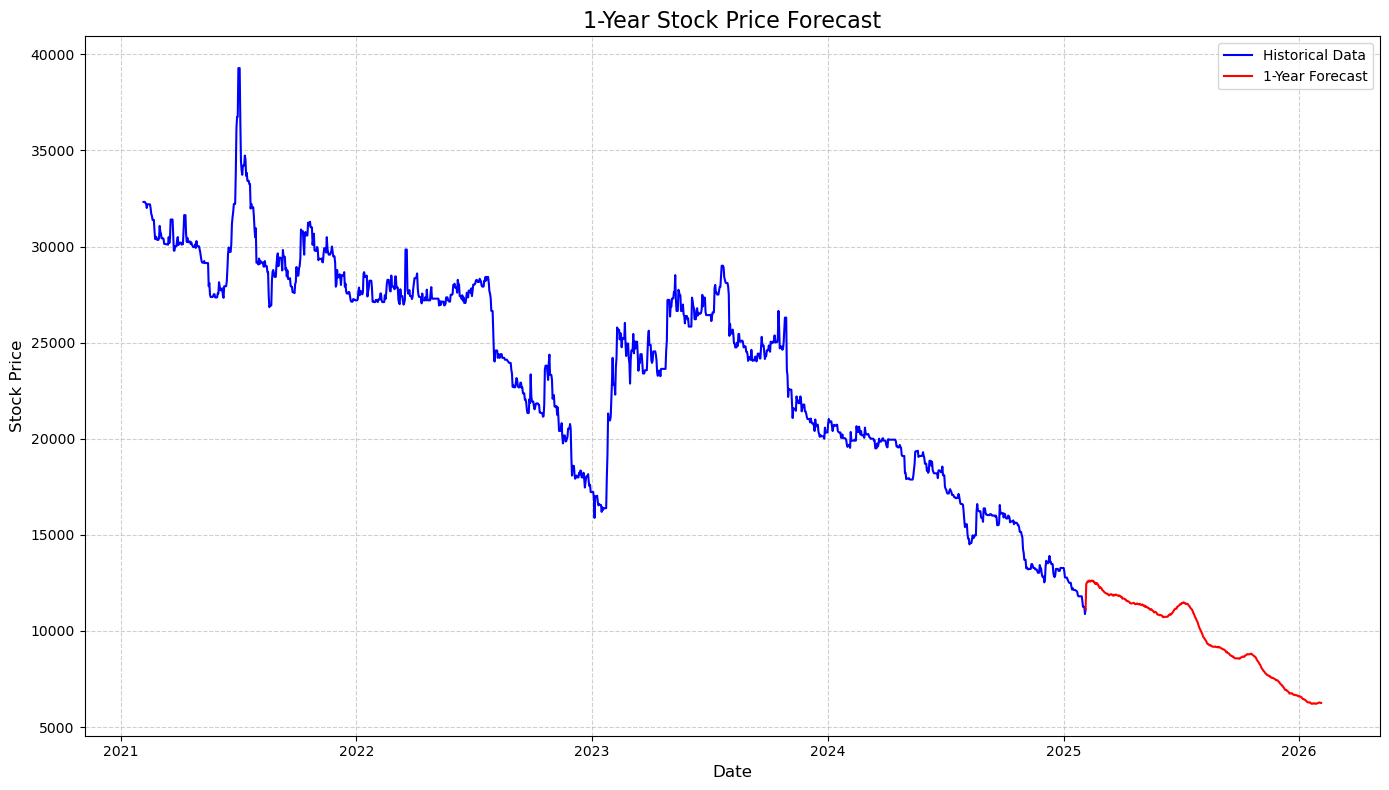

In [33]:
import matplotlib.pyplot as plt

# Find the last point of historical data
last_historical_date = df['ds'].max()
last_historical_value = df.loc[df['ds'] == last_historical_date, 'y'].values[0]

# Add the last historical point to the forecast for smooth transition
one_year_forecast = forecast[forecast['ds'] > last_historical_date]
smooth_forecast = pd.concat([
    pd.DataFrame({'ds': [last_historical_date], 'yhat': [last_historical_value]}),
    one_year_forecast[['ds', 'yhat']]
])

# Visualization: Historical and Forecasted Data
plt.figure(figsize=(14, 8))

# Plot historical data
plt.plot(df['ds'], df['y'], label='Historical Data', color='blue')

# Plot 1-year forecast with a smooth transition
plt.plot(smooth_forecast['ds'], smooth_forecast['yhat'], label='1-Year Forecast', color='red')

# # Add confidence intervals for the forecast
# plt.fill_between(
#     one_year_forecast['ds'], 
#     one_year_forecast['yhat_lower'], 
#     one_year_forecast['yhat_upper'], 
#     color='pink', alpha=0.3, label='Uncertainty Interval'
# )

# Add title, labels, and legend
plt.title('1-Year Stock Price Forecast', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Stock Price', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


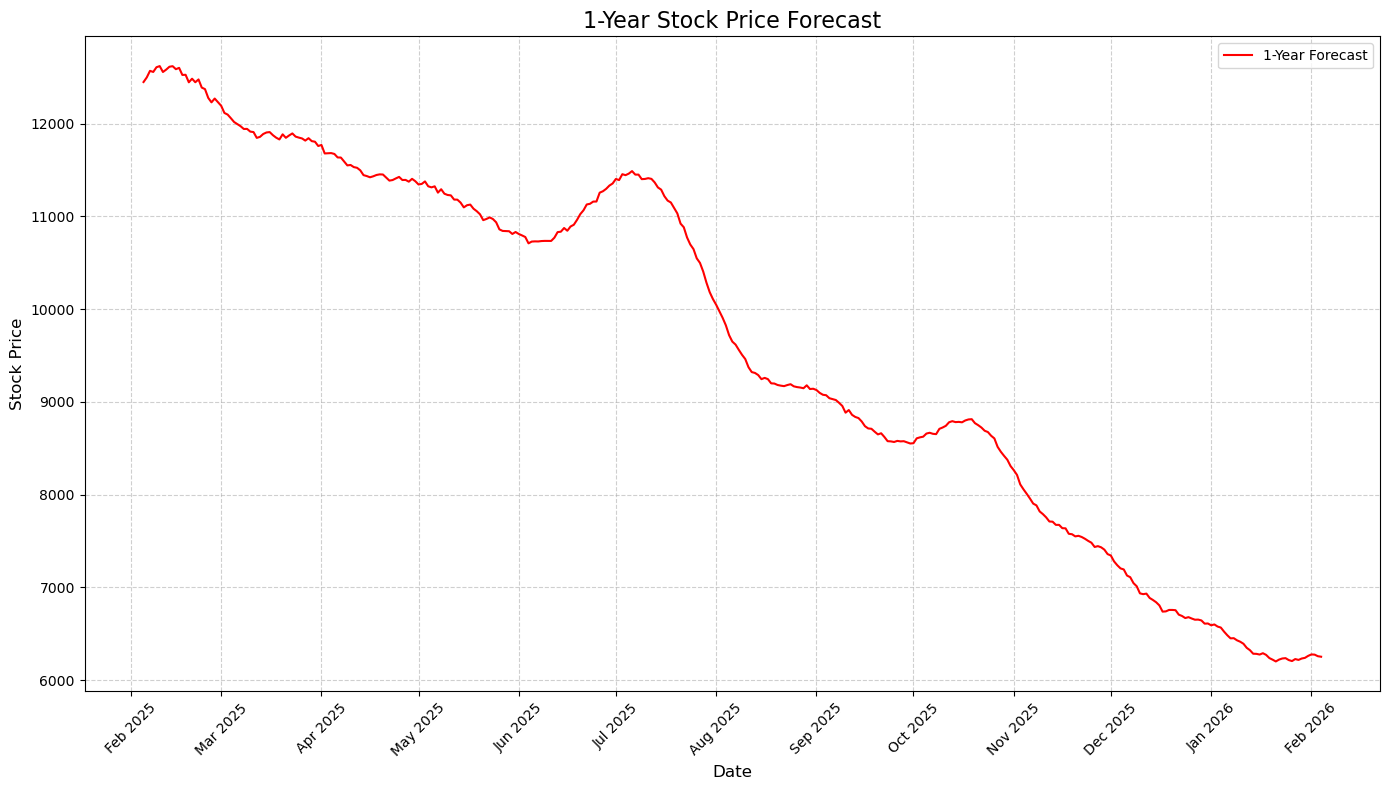

In [34]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Visualization of 1-Year Ahead Prediction with Monthly X-Ticks
plt.figure(figsize=(14, 8))

# Plot 1-year forecast
plt.plot(one_year_forecast['ds'], one_year_forecast['yhat'], label='1-Year Forecast', color='red')

# Add title and labels
plt.title('1-Year Stock Price Forecast', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Stock Price', fontsize=12)

# Add x-ticks for every month
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Major ticks: every month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format as "Month Year"
plt.xticks(rotation=45, fontsize=10)

# Add legend and grid
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Show the plot
plt.show()

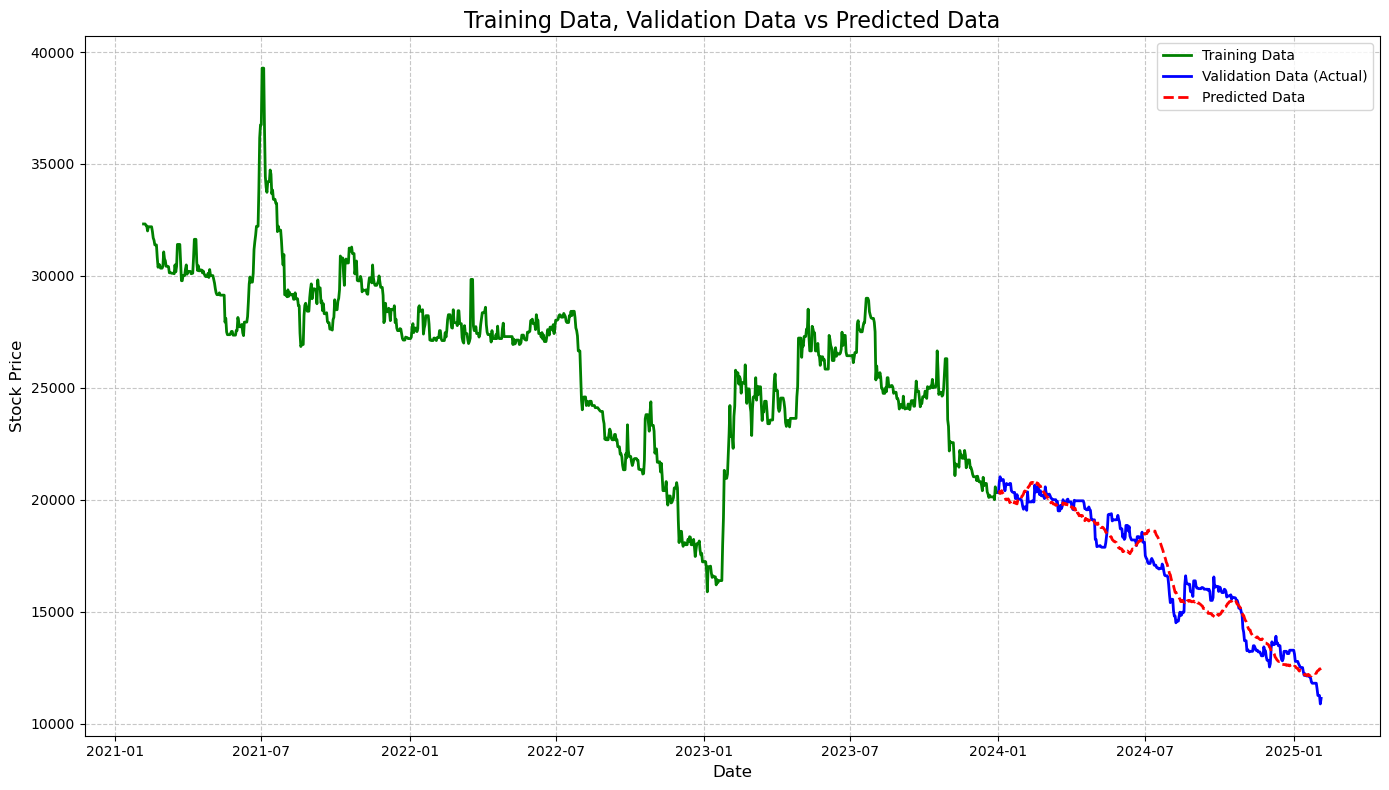

In [52]:
import matplotlib.pyplot as plt

# Visualization: Training Data, Validation Data vs Predicted Data
plt.figure(figsize=(14, 8))

# Plot training data
plt.plot(df_train['ds'], df_train['y'], label='Training Data', color='green', linewidth=2)

# Plot validation data (actual values)
plt.plot(df_test['ds'], df_test['y'], label='Validation Data (Actual)', color='blue', linewidth=2)

# Plot predicted values for the validation period
plt.plot(validation_forecast['ds'], validation_forecast['yhat'], label='Predicted Data', color='red', linestyle='--', linewidth=2)

# Add title, labels, and legend
plt.title('Training Data, Validation Data vs Predicted Data', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Stock Price', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
forecast[['ds', 'yhat']].tail(10)

`Insight`

Added MAPE calculation for comprehensive error evaluation

Enhanced parameter grid with:

Changepoint range adjustment

Custom yearly seasonality with Fourier order tuning

More granular parameter options

Implemented proper future forecasting with:

Full dataset training for final model

365-day forecast period

Synthetic regressor generation (replace with real data in practice)

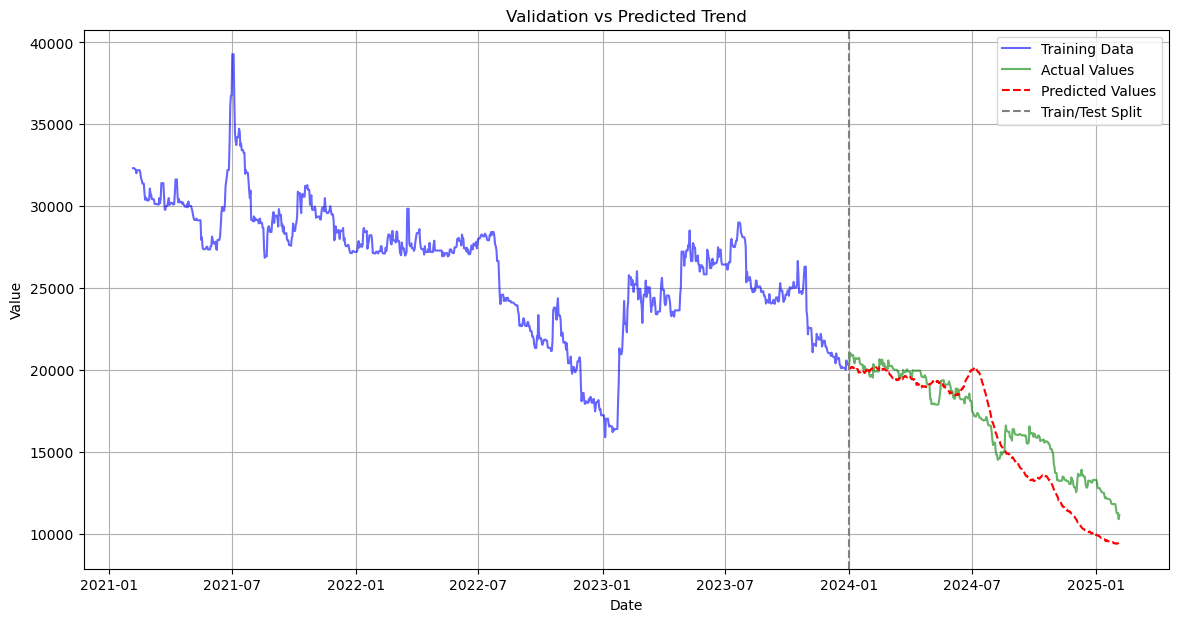

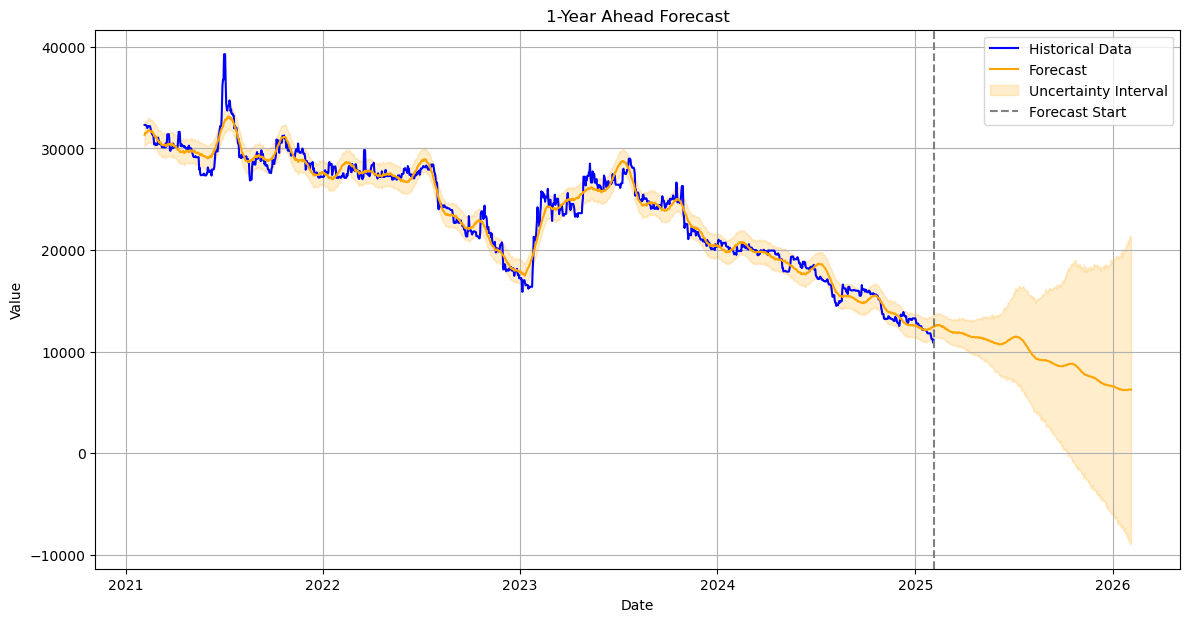

In [38]:
# # Visualization 1: Validation vs Predicted Trend (Test Period)
# plt.figure(figsize=(14, 7))
# # Plot training data
# plt.plot(df_train['ds'], df_train['y'], label='Training Data', color='blue', alpha=0.6)
# # Plot actual test values
# plt.plot(df_test['ds'], df_test['y'], label='Actual Values', color='green', alpha=0.6)
# # Plot predicted values
# plt.plot(results['ds'], results['yhat'], label='Predicted Values', color='red', linestyle='--')
# plt.axvline(pd.to_datetime('2024-01-01'), color='gray', linestyle='--', label='Train/Test Split')
# plt.title('Validation vs Predicted Trend')
# plt.xlabel('Date')
# plt.ylabel('Value')
# plt.legend()
# plt.grid(True)
# plt.show()

# # Visualization 2: 1-Year Ahead Forecast
# plt.figure(figsize=(14, 7))
# # Plot historical data
# plt.plot(df['ds'], df['y'], label='Historical Data', color='blue')
# # Plot forecast
# plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='orange')
# # Plot uncertainty interval
# plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], 
#                  color='orange', alpha=0.2, label='Uncertainty Interval')
# plt.axvline(df['ds'].max(), color='gray', linestyle='--', label='Forecast Start')
# plt.title('1-Year Ahead Forecast')
# plt.xlabel('Date')
# plt.ylabel('Value')
# plt.legend()
# plt.grid(True)
# plt.show()

In [ ]:
# df['rolling_mean'] = df['y'].rolling(window=30).mean()  # 30-day moving average
# df['rolling_std'] = df['y'].rolling(window=30).std()    # 30-day volatility

# plt.figure(figsize=(12,6))
# plt.plot(df['ds'], df['y'], label='Stock Price', alpha=0.5)
# plt.plot(df['ds'], df['rolling_mean'], label='30-day Moving Average', color='red')
# plt.fill_between(df['ds'], df['rolling_mean'] - df['rolling_std'], df['rolling_mean'] + df['rolling_std'], 
#                  color='gray', alpha=0.3, label='Rolling Volatility')
# plt.title('Stock Price with Moving Average & Volatility')
# plt.xlabel('Date')
# plt.ylabel('Stock Price')
# plt.legend()
# plt.grid()
# plt.show()


In [ ]:
# import seaborn as sns

# # Extract month from datetime column
# df['month'] = df['ds'].dt.month

# # Create boxplot for stock price per month
# plt.figure(figsize=(12,6))
# sns.boxplot(x=df['month'], y=df['y'], palette='coolwarm')
# plt.title('Stock Price Distribution by Month')
# plt.xlabel('Month')
# plt.ylabel('Stock Price')
# plt.grid()
# plt.show()


In [ ]:
# from statsmodels.tsa.seasonal import seasonal_decompose

# # Decompose the stock price time series
# decomposition = seasonal_decompose(df.set_index('ds')['y'], period=365, model='additive')

# # Plot trend, seasonality, and residuals
# plt.figure(figsize=(10,8))

# plt.subplot(3,1,1)
# plt.plot(decomposition.trend, label='Trend')
# plt.legend()

# plt.subplot(3,1,2)
# plt.plot(decomposition.seasonal, label='Seasonality', color='green')
# plt.legend()

# plt.subplot(3,1,3)
# plt.plot(decomposition.resid, label='Residuals', color='red')
# plt.legend()

# plt.suptitle('Time Series Decomposition')
# plt.show()